In [2]:
import numpy as np
import os
import glob
import random
import sys
from tqdm import tqdm
import time
import datetime
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, InputSpec, Input, concatenate, LeakyReLU
import nibabel as nib
from skimage.transform import resize
from skimage.feature import canny
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sys.path.append('./synth')
import voxelmorph as vxm
import src.networks as networks
#import src.augment as augment
import src.losses as losses
from synth.TFTools import *
import surface_distance
from utils import compute_surface_metrics, compute_TRE

from synth.GANModel import Generator, Discriminator
import patches

from matplotlib import colors as mplcolors
def colormap_binary(fg, bg=(0,0,0), alpha=None):
    fg = mplcolors.to_rgb(fg)
    bg = mplcolors.to_rgb(bg)
    cmap = mplcolors.LinearSegmentedColormap.from_list('Binary', (bg,fg), 256)
    if alpha is not None:
        cmap._init()
        cmap._lut[:,-1] = np.linspace(0, alpha, cmap.N+3)
    return cmap
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('dark_background')

In [3]:
import pystrum.pynd.ndutils as nd
def jacobian_determinant(disp):
    """
    jacobian determinant of a displacement field.
    NB: to compute the spatial gradients, we use np.gradient.
    Parameters:
        disp: 2D or 3D displacement field of size [*vol_shape, nb_dims], 
              where vol_shape is of len nb_dims
    Returns:
        jacobian determinant (scalar)
    """

    # check inputs
    volshape = disp.shape[:-1]
    nb_dims = len(volshape)
    assert len(volshape) in (2, 3), 'flow has to be 2D or 3D'

    # compute grid
    grid_lst = nd.volsize2ndgrid(volshape)
    grid = np.stack(grid_lst, len(volshape))

    # compute gradients
    J = np.gradient(disp + grid)

    # 3D glow
    if nb_dims == 3:
        dx = J[0]
        dy = J[1]
        dz = J[2]

        # compute jacobian components
        Jdet0 = dx[..., 0] * (dy[..., 1] * dz[..., 2] - dy[..., 2] * dz[..., 1])
        Jdet1 = dx[..., 1] * (dy[..., 0] * dz[..., 2] - dy[..., 2] * dz[..., 0])
        Jdet2 = dx[..., 2] * (dy[..., 0] * dz[..., 1] - dy[..., 1] * dz[..., 0])

        return Jdet0 - Jdet1 + Jdet2

    else: # must be 2 
        
        dfdx = J[0]
        dfdy = J[1] 
        
        return dfdx[..., 0] * dfdy[..., 1] - dfdy[..., 0] * dfdx[..., 1]
    
def compute_negative_jacobian(disp):
    J = jacobian_determinant(disp)
    return np.sum(J<0)/np.prod(J.shape)

In [ ]:
config = dict()
config['train_dir'] = r"\\istar-blackhole\data2\data2\RadOnc_Brain\NonRigid_Training_CBCT"
config['valid_dir'] = r"\\istar-blackhole\data2\data2\RadOnc_Brain\Validation"

fig, ax = plt.subplots(1,1)
#temp = []
for i in tqdm(range(10)):
    data = np.load(glob.glob(os.path.join(config['valid_dir'],'*.npz'))[i], allow_pickle=True)
    mask = data['ventricle_fixed']
    phi = np.squeeze(data['flow'])
    phi = np.linalg.norm(phi, axis=-1)
    #temp.append(phi[mask>0])
    if i==0:
        temp = phi[mask>0]
    else:
        temp = np.append(temp, phi[mask>0])
            
# ax.hist(temp)
# plt.show()

In [ ]:
from scipy.io import savemat
savemat('phi_mag.mat',{'mag': temp})

In [ ]:
sns.set(context='paper',style='white',font_scale = 2)
fig, ax = plt.subplots(1,1, figsize=(6,4))
plt.hist(temp, bins=12, color='black')
plt.xticks([0,2,4,6,8,10,12])
plt.xlabel('Deformation Magnitude (mm)')
plt.ylabel('Counts')
plt.show()

In [ ]:
valid_ds = np.load(glob.glob(os.path.join(config['valid_dir'],'*.npz'))[5])
mr_moving = tf.cast(np.expand_dims(resize(valid_ds['moving_img'], config['image_size']),axis=[0,-1]), tf.float32)
ct_fixed = tf.cast(np.expand_dims(resize(valid_ds['fixed_img'], config['image_size']),axis=[0,-1]), tf.float32)
ct_mask = valid_ds['ventricle_fixed'].astype(np.int16)
for val in [6,20,24,30,9]:
    ct_mask[ct_mask==val] -= 1
ct_mask =resize(ct_mask.astype(np.float32), config['image_size'],order=0, anti_aliasing=False)

In [ ]:
mr_reg = nib.load(r'E:\c_users\U01_BrainRegistration\Validation\SyN\MR_CT\Validation_05_MR_registered.nii.gz').get_fdata()
mr_reg = tf.cast(np.expand_dims(resize(mr_reg, config['image_size']),axis=[0,-1]), tf.float32)

In [ ]:
colors = ['lime','magenta','yellow','cyan','orange','purple','pink']
ct_moving, _ = G(mr_moving)
mr_fixed, _ = F(ct_fixed)
flow = R([mr_moving, ct_moving, mr_fixed, ct_fixed])
# _, flow = R([ct_moving, ct_fixed])
# _, flow = R([mr_moving, mr_fixed])
mr_reg = vxm.layers.SpatialTransformer(interp_method='linear', indexing='ij')([mr_moving, flow])

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(np.squeeze(mr_reg.numpy())[:,:,70].T, cmap='gray')
#ax.imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
for i,val in enumerate([1,2,23,5,19,29,8]):
    ax.imshow(canny(np.squeeze(ct_mask==val)[:,:,70], sigma=1).T, cmap=colormap_binary(colors[i], alpha=1))
ax.axis('off')
plt.show()
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(np.flip(np.squeeze(mr_reg.numpy())[:,90,:].T), cmap='gray')
for i,val in enumerate([1,2,23,5,19,29,8]):
    ax.imshow(np.flip(canny(np.squeeze(ct_mask==val)[:,90,:], sigma=1).T), cmap=colormap_binary(colors[i], alpha=1))
ax.axis('off')
plt.show()

# Full Image Registration

In [ ]:
config = dict()
config['train_dir'] = r"\\istar-blackhole\data2\data2\RadOnc_Brain\NonRigid_Training_CBCT"
config['valid_dir'] = r"\\istar-blackhole\data2\data2\RadOnc_Brain\Validation"

config['image_size'] = [128,160,128]
config['R_path'] = './checkpoint/VM/MR_MR/checkpoint_MR_MR_174.h5'#'./checkpoint/VM/CT_CT/checkpoint_CT_CT_174.h5'
config['G_path'] = './checkpoint/LSGAN/LSGAN_MR_CT_prob_generator_149.h5'
config['F_path'] = './checkpoint/LSGAN/LSGAN_CT_MR_prob_generator_149.h5'

In [ ]:
G = Generator(config['image_size']+[1], prob=True)
G.load_weights(config['G_path'])
F = Generator(config['image_size']+[1], prob=True)
F.load_weights(config['F_path'])

In [ ]:
nf_enc = [16, 32, 64, 128, 128]
nf_dec = [128, 64, 32, 16]
R = networks.deformable_net2(config['image_size'], nf_enc, nf_dec, n_channel=1)
R.load_weights(config['R_path'])

In [ ]:
dice_ep = pd.DataFrame()
spacing = [1.5,1.5,1.5]
for ep in range(1):
    #R.load_weights('./checkpoint/VM/MR_CT/checkpoint_MR_CT_MI_{}.h5'.format(249+ep*25))
    dice_before_total = []
    TRE_before = []
    hd_before_total = []
    sd_before_total = []
    dice_after_total = []
    TRE_after = []
    hd_after_total = []
    sd_after_total = []
    J = []
    duration = []
    mask_val = [0,1,2,23,24,5,19,29,8]

    for i in tqdm(range(10)):
        valid_ds = np.load(glob.glob(os.path.join(config['valid_dir'],'*.npz'))[i])
        example_ct = valid_ds['fixed_img']
        example_mr = valid_ds['moving_img']
        ct_fixed = tf.cast(np.expand_dims(resize(example_ct, config['image_size']),axis=[0,-1]), tf.float32)
        mr_moving = tf.cast(np.expand_dims(resize(example_mr, config['image_size']),axis=[0,-1]), tf.float32)
        start = time.time()
#         mr_fixed, _ = F(ct_fixed)
#         _, flow = R([mr_moving, mr_fixed])
        ct_moving, _ = G(mr_moving)
        _, flow = R([ct_moving, ct_fixed])
#         _, flow = R([mr_moving, ct_fixed])

        mr_reg = vxm.layers.SpatialTransformer(interp_method='linear', indexing='ij')([mr_moving, flow])
#         duration.append(time.time()-start)
#         J.append(compute_negative_jacobian(np.squeeze(flow.numpy())))
        fig, ax = plt.subplots(1,4,figsize=(20,20))
        ax[0].imshow(np.squeeze(mr_moving.numpy())[:,:,70].T, cmap='gray')
        ax[0].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
        ax[1].imshow(np.squeeze(mr_fixed.numpy())[:,:,70].T, cmap='gray')
        ax[1].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
        ax[2].imshow(np.squeeze(mr_reg.numpy())[:,:,70].T, cmap='gray')
        ax[2].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
        ax[3].imshow(np.squeeze(ct_fixed.numpy())[:,:,70].T, cmap='gray', vmin=0.4, vmax=0.9)
        ax[3].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
        plt.show()
#         ventricle_fixed = valid_ds['ventricle_fixed']
#         ventricle_moving = valid_ds['ventricle_moving']

#         ventricle_fixed = tf.cast(np.expand_dims(resize(ventricle_fixed, config['image_size'], order=0, anti_aliasing=False), [0,-1]), tf.float32)
#         ventricle_moving = tf.cast(np.expand_dims(resize(ventricle_moving, config['image_size'], order=0, anti_aliasing=False), [0,-1]), tf.float32)      
#         ventricle_registered = transformer([ventricle_moving, flow])
#         TRE_before.append(compute_TRE(np.squeeze(ventricle_fixed.numpy()), np.squeeze(ventricle_moving.numpy()), spacing))
#         TRE_after.append(compute_TRE(np.squeeze(ventricle_fixed.numpy()), np.squeeze(ventricle_registered.numpy()), spacing))
#         for val in [6,20,30,9]:
#             ventricle_fixed[ventricle_fixed==val] -= 1
#             ventricle_moving[ventricle_moving==val] -= 1
#         mask_fixed = np.zeros(ventricle_fixed.shape)
#         mask_moving = np.zeros(ventricle_moving.shape)
#         for val in mask_val[1:]:
#             mask_fixed += (ventricle_fixed==val)
#             mask_moving += (ventricle_moving==val)
#         ventricle_fixed = np.multiply(ventricle_fixed, mask_fixed)
#         ventricle_moving = np.multiply(ventricle_moving, mask_moving)
    
#         ventricle_fixed = tf.cast(np.expand_dims(resize(ventricle_fixed, config['image_size'], order=0, anti_aliasing=False), [0,-1]), tf.float32)
#         ventricle_moving = tf.cast(np.expand_dims(resize(ventricle_moving, config['image_size'], order=0, anti_aliasing=False), [0,-1]), tf.float32)
#         transformer = vxm.layers.SpatialTransformer(interp_method='nearest', indexing='ij')
#         ventricle_registered = transformer([ventricle_moving, flow])
                        
#         TRE_before.append(compute_TRE(np.squeeze(ventricle_fixed.numpy()), np.squeeze(ventricle_moving.numpy()), spacing))
#         TRE_after.append(compute_TRE(np.squeeze(ventricle_fixed.numpy()), np.squeeze(ventricle_registered.numpy()), spacing))
        
#         dice_before = []
#         hd_before = []
#         sd_before = []
#         dice_after= []
#         hd_after = []
#         sd_after = []

#         for val in mask_val[1:]:
#             mask_fixed = tf.cast(ventricle_fixed==val, tf.float32)
#             mask_moving = tf.cast(ventricle_moving==val, tf.float32)
#             mask_registered = tf.cast(ventricle_registered==val, tf.float32)
#             dice_before.append(-losses.binary_dice(mask_fixed,mask_moving).numpy())
#             dice_after.append(-losses.binary_dice(mask_fixed,mask_registered).numpy())
#             metrics_before = compute_surface_metrics(np.squeeze(mask_fixed.numpy())==1, np.squeeze(mask_moving.numpy())==1)
#             metrics_after = compute_surface_metrics(np.squeeze(mask_fixed.numpy())==1, np.squeeze(mask_registered.numpy())==1)
#             hd_before.append(metrics_before['hd'])
#             hd_after.append(metrics_after['hd'])
#             sd_before.append(metrics_before['avg_dist'])
#             sd_after.append(metrics_after['avg_dist'])
#         dice_before_total.append(dice_before)
#         dice_after_total.append(dice_after)
#         hd_before_total.append(hd_before)
#         hd_after_total.append(hd_after)
#         sd_before_total.append(sd_before)
#         sd_after_total.append(sd_after)
         
#     d = {'Dice':np.reshape(np.array(dice_after_total),-1),'HD':np.reshape(np.array(hd_after_total),-1), 'SD':np.reshape(np.array(sd_after_total),-1),
#       'anatomy':['3rd', '4th','LV', 'RV','amygdala', 'hippocampus', 'thalamus', 'caudate']*10,'ep':[124+ep*25]*80, 'method':['MR_CT']*80}
#     d = pd.DataFrame(data=d)
#     dice_ep = pd.concat([dice_ep, d])


In [ ]:
print(np.mean(J), np.std(J))
print(np.mean(duration), np.std(duration))

In [ ]:
df = df[df['method']!='MR_MR']
df = pd.concat([df, d])

In [ ]:
pd.set_option('display.max_rows', None)
dice_ep.groupby(['anatomy','ep']).agg({"Dice": ["mean"]})

In [ ]:
df = pd.read_csv('MR_CT_2channel_allmetrics.csv')
d = dice_ep[dice_ep['ep']==249]
d.drop(columns=['ep'])
# np.unique(d['method'])
# d = d[d['method']=='Synth+VM']
d.loc[d['method']=='MR_CT','method'] = 'MI-VM'
# df = df[df['method']!='CT_CT']
df = pd.concat([df, d])
#df.loc[df['method']=='E2E:NCC','method'] = 'E2E:CT'

In [ ]:
# d1 = {'Dice':np.reshape(np.array(dice_before_total),-1),
#       'anatomy':['3rd', '4th','LV', 'RV','amygdala', 'hippocampus', 'thalamus', 'caudate']*10,'method':['rigid']*80}
# d1 = pd.DataFrame(data=d1)
d2 = {'Dice':np.reshape(np.array(dice_after_total),-1),
      'anatomy':['3rd', '4th','LV', 'RV','amygdala', 'hippocampus', 'thalamus', 'caudate']*10,'method':['CT_CT_prob']*80}
d2 = pd.DataFrame(data=d2)
# df = pd.concat([d1,d2])
df = pd.concat([df,d2])

In [ ]:
df = pd.read_csv('MR_CT_2channel.csv')

In [ ]:
plt.figure(figsize=(20,8))
#sns.set(context='paper',style='whitegrid',font_scale = 3)
#sns.set(style='darkgrid', font_scale=2, rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'grid.linewidth':1, 'axes.linewidth':1})
sns.set(style='whitegrid', font_scale = 2)
#with plt.rc_context({'axes.edgecolor':'white', 'xtick.color':'white', 'ytick.color':'black', 'figure.facecolor':'black'}):
g = sns.boxplot(y='Dice', x='anatomy', data=df, hue='method', hue_order=['rigid','CT_CT','E2E:CT', 'MR_MR', '2channel_fusion'], width=0.7,linewidth=4, palette='Set1_r',
                order=['3rd', '4th','LV','amygdala', 'hippocampus', 'caudate', 'thalamus'])
g.set(ylim=(0.0, 1.0), xlabel=None, ylabel=None)
plt.legend(fontsize='x-small', loc='lower right')
#plt.xticks(rotation=30, weight='bold')
plt.yticks(weight='bold')
plt.show()

In [ ]:
df.to_csv('MR_CT_2channel_allmetrics.csv')

## 2channel

In [ ]:
config = dict()
config['data_dir'] = r"\\istar-blackhole\data2\RadOnc_Brain\NonRigid_Training_CBCT"
config['valid_dir'] = r"\\istar-blackhole\data2\RadOnc_Brain\Validation"
config['write_dir'] = r"\\istar-tauceti\c_users\U01_BrainRegistration\temp\CBCT_synth"
config['image_size'] = [128,160,128]#[192,240,192]

config['G_path'] = './checkpoint/LSGAN/LSGAN_MR_CT_prob_generator_149.h5'
config['F_path'] = './checkpoint/LSGAN/LSGAN_CT_MR_prob_generator_149.h5'
G = Generator(config['image_size']+[1], prob=True)
G.load_weights(config['G_path'])
F = Generator(config['image_size']+[1], prob=True)
F.load_weights(config['F_path'])

In [ ]:
def registration_model(config, G, F):
    nf_enc = [16, 32, 64, 128, 128]
    nf_dec = [128, 64, 32, 16]
    R = networks.deformable_net2(config['image_size'], nf_enc, nf_dec, n_channel=1, use_svf=False)

    mr_moving = Input(shape=config['image_size']+[1])
    cbct_fixed = Input(shape=config['image_size']+[1])

    flow_MR = R_MR([mr_moving, mr_fixed])
    flow_CT = R_CT([ct_moving, ct_fixed])
    flow = concatenate([flow_MR, flow_CT])
    flow = tf.keras.layers.Conv3D(3, 3, strides=1, padding='same')(flow)
#     flow = tf.keras.layers.Conv3D(6, 3, strides=1, padding='same')(flow)
#     flow = tf.keras.layers.Conv3D(3, 1, strides=1)(flow)
    flow = vxm.layers.VecInt(method='ss', name='flow', int_steps=7)(flow)
    R = Model(inputs=[mr_moving, ct_moving, mr_fixed, ct_fixed], outputs=flow)
    return R
R = networks.deformable_net2(config['image_size'], [16, 32, 64, 128, 128], [128, 64, 32, 16], n_channel=1)
R.load_weights('./checkpoint/VM/MR_CT_CBCT_CT/model2_MR_CBCT_intramodal_174.h5')

In [ ]:
def registration_model(config):
    nf_enc = [16, 32, 64, 128, 128]
    nf_dec = [128, 64, 32, 16]
    R_CT = networks.deformable_net2(config['image_size'], nf_enc, nf_dec, n_channel=1, use_svf=True)
    R_MR = networks.deformable_net2(config['image_size'], nf_enc, nf_dec, n_channel=1, use_svf=True)

    mr_moving = Input(shape=config['image_size']+[1])
    ct_fixed = Input(shape=config['image_size']+[1])
    mr_fixed = Input(shape=config['image_size']+[1])
    ct_moving = Input(shape=config['image_size']+[1])

    flow_MR = R_MR([mr_moving, mr_fixed])
    flow_CT = R_CT([ct_moving, ct_fixed])
    flow = concatenate([flow_MR, flow_CT])
    flow = tf.keras.layers.Conv3D(3, 3, strides=1, padding='same')(flow)
#     flow = tf.keras.layers.Conv3D(6, 3, strides=1, padding='same')(flow)
#     flow = tf.keras.layers.Conv3D(3, 1, strides=1)(flow)
    flow = vxm.layers.VecInt(method='ss', name='flow', int_steps=7)(flow)
    R = Model(inputs=[mr_moving, ct_moving, mr_fixed, ct_fixed], outputs=flow)
    return R

R = registration_model(config)
R.load_weights('./checkpoint/VM/2channel/fusion1/checkpoint_2channel_fusion_174.h5')

In [ ]:
def registration_model(config):
    nf = [16, 32, 64, 128]
    R_CT = networks.unet_attention(config['image_size'], nf)
    R_MR = networks.unet_attention(config['image_size'], nf)

    mr_moving = Input(shape=config['image_size']+[1])
    ct_fixed = Input(shape=config['image_size']+[1])
    mr_fixed = Input(shape=config['image_size']+[1])
    ct_moving = Input(shape=config['image_size']+[1])

    flow_MR = R_MR([mr_moving, mr_fixed])
    flow_CT = R_CT([ct_moving, ct_fixed])
    flow = concatenate([flow_MR, flow_CT])

    flow = tf.keras.layers.Conv3D(32, 3, strides=1, padding='same')(flow)
    flow = InstanceNormalization()(flow)
    flow = LeakyReLU()(flow)
    flow = tf.keras.layers.Conv3D(3, 3, strides=1, padding='same')(flow)
    flow = vxm.layers.VecInt(method='ss', name='flow', int_steps=7)(flow)
    R = Model(inputs=[mr_moving, ct_moving, mr_fixed, ct_fixed], outputs=flow)
    return R

R = registration_model(config)
R.load_weights('./checkpoint/VM/2channel/uncertainty_v2/checkpoint_2channel_fusion_attention_uncertainty_weighting_124.h5')

In [ ]:
dice_ep = pd.DataFrame()
spacing = [1.5,1.5,1.5]
transformer = vxm.layers.SpatialTransformer(interp_method='nearest', indexing='ij')

for ep in range(5):
    R.load_weights('./checkpoint/VM/2channel/uncertainty_v2/checkpoint_2channel_fusion_attention_uncertainty_weighting_{}.h5'.format(99+ep*25))
    dice_before_total = []
    TRE_before = []
    hd_before_total = []
    sd_before_total = []
    dice_after_total = []
    TRE_after = []
    hd_after_total = []
    sd_after_total = []
    J = []
    duration = []
    mask_val = [0,1,2,23,24,5,19,29,8]

    for i in tqdm(range(10)):
        valid_ds = np.load(glob.glob(os.path.join(config['valid_dir'],'*.npz'))[i])
        example_ct = valid_ds['fixed_img']
        example_mr = valid_ds['moving_img']
        ct_fixed = tf.cast(np.expand_dims(resize(example_ct, config['image_size']),axis=[0,-1]), tf.float32)
        mr_moving = tf.cast(np.expand_dims(resize(example_mr, config['image_size']),axis=[0,-1]), tf.float32)
#         start = time.time()
        ct_moving, _ = G(mr_moving)
        mr_fixed, _ = F(ct_fixed)
        flow = R([mr_moving, ct_moving, mr_fixed, ct_fixed])
        
        mr_reg = vxm.layers.SpatialTransformer(interp_method='linear', indexing='ij')([mr_moving, flow])
#         duration.append(time.time()-start)
#         J.append(compute_negative_jacobian(np.squeeze(flow.numpy())))
#         fig, ax = plt.subplots(1,3,figsize=(20,20))
#         ax[0].imshow(np.squeeze(mr_moving.numpy())[:,:,70].T, cmap='gray', vmin=0.1, vmax=0.4)
#         ax[0].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         ax[1].imshow(np.squeeze(mr_reg.numpy())[:,:,70].T, cmap='gray', vmin=0.1, vmax=0.4)
#         ax[1].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         ax[2].imshow(np.squeeze(ct_fixed.numpy())[:,:,70].T, cmap='gray', vmin=0.4, vmax=0.9)
#         ax[2].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         plt.show()
        ventricle_fixed = valid_ds['ventricle_fixed']
        ventricle_moving = valid_ds['ventricle_moving']
        
#         ventricle_fixed = tf.cast(np.expand_dims(resize(ventricle_fixed, config['image_size'], order=0, anti_aliasing=False), [0,-1]), tf.float32)
#         ventricle_moving = tf.cast(np.expand_dims(resize(ventricle_moving, config['image_size'], order=0, anti_aliasing=False), [0,-1]), tf.float32)      
#         ventricle_registered = transformer([ventricle_moving, flow])
#         TRE_before.append(compute_TRE(np.squeeze(ventricle_fixed.numpy()), np.squeeze(ventricle_moving.numpy()), spacing))
#         TRE_after.append(compute_TRE(np.squeeze(ventricle_fixed.numpy()), np.squeeze(ventricle_registered.numpy()), spacing))
        
        for val in [6,20,30,9]:
            ventricle_fixed[ventricle_fixed==val] -= 1
            ventricle_moving[ventricle_moving==val] -= 1
        mask_fixed = np.zeros(ventricle_fixed.shape)
        mask_moving = np.zeros(ventricle_moving.shape)
        for val in mask_val[1:]:
            mask_fixed += (ventricle_fixed==val)
            mask_moving += (ventricle_moving==val)
        ventricle_fixed = np.multiply(ventricle_fixed, mask_fixed)
        ventricle_moving = np.multiply(ventricle_moving, mask_moving)
    
        ventricle_fixed = tf.cast(np.expand_dims(resize(ventricle_fixed, config['image_size'], order=0, anti_aliasing=False), [0,-1]), tf.float32)
        ventricle_moving = tf.cast(np.expand_dims(resize(ventricle_moving, config['image_size'], order=0, anti_aliasing=False), [0,-1]), tf.float32)        
        ventricle_registered = transformer([ventricle_moving, flow])
                             
        dice_before = []
        hd_before = []
        sd_before = []
        dice_after= []
        hd_after = []
        sd_after = []

        for val in mask_val[1:]:
            mask_fixed = tf.cast(ventricle_fixed==val, tf.float32)
            mask_moving = tf.cast(ventricle_moving==val, tf.float32)
            mask_registered = tf.cast(ventricle_registered==val, tf.float32)
            dice_before.append(-losses.binary_dice(mask_fixed,mask_moving).numpy())
            dice_after.append(-losses.binary_dice(mask_fixed,mask_registered).numpy())
            metrics_before = compute_surface_metrics(np.squeeze(mask_fixed.numpy())==1, np.squeeze(mask_moving.numpy())==1)
            metrics_after = compute_surface_metrics(np.squeeze(mask_fixed.numpy())==1, np.squeeze(mask_registered.numpy())==1)
            hd_before.append(metrics_before['hd'])
            hd_after.append(metrics_after['hd'])
            sd_before.append(metrics_before['avg_dist'])
            sd_after.append(metrics_after['avg_dist'])
        dice_before_total.append(dice_before)
        dice_after_total.append(dice_after)
        hd_before_total.append(hd_before)
        hd_after_total.append(hd_after)
        sd_before_total.append(sd_before)
        sd_after_total.append(sd_after)
         
    d = {'Dice':np.reshape(np.array(dice_after_total),-1),'HD':np.reshape(np.array(hd_after_total),-1), 'SD':np.reshape(np.array(sd_after_total),-1),
      'anatomy':['3rd', '4th','LV', 'RV','amygdala', 'hippocampus', 'thalamus', 'caudate']*10,'ep':[99+ep*25]*80, 'method':['S+R:2channel+uncertainty']*80}
    d = pd.DataFrame(data=d)
    dice_ep = pd.concat([dice_ep, d])

In [ ]:
print(np.mean(J), np.std(J))
print(np.mean(duration), np.std(duration))

In [ ]:
# d0 = pd.DataFrame()
# for i in range(len(TRE_before)):
#     temp_df = {'TRE':TRE_before[i], 'method':['rigid']*len(TRE_before[i])}
#     temp_df = pd.DataFrame(data=temp_df)
#     d0 = pd.concat([d0, temp_df])
TRE = pd.read_csv('TRE.csv')
d1 = pd.DataFrame()
for i in range(len(TRE_after)):
    temp_df = {'TRE':TRE_after[i], 'method':['MI-VM']*len(TRE_after[i])}
    temp_df = pd.DataFrame(data=temp_df)
    d1 = pd.concat([d1, temp_df])

TRE = pd.concat([TRE,d1])
TRE.groupby(['method']).agg({'TRE':['mean','std']})
#TRE.to_csv('TRE.csv')

In [ ]:
TRE = pd.read_csv('TRE.csv')
TRE.groupby(['method']).agg({'TRE':['mean','std']})
#TRE.to_csv('TRE.csv')

In [ ]:
pd.set_option('display.max_rows', None)
dice_ep.groupby(['anatomy','ep']).agg({"Dice": ["mean"], "SD": ["mean"]})

In [ ]:
d = dice_ep[dice_ep['ep']==124]
d['method'] = ['temp']*80
df = pd.read_csv('MR_CT_2channel_allmetrics.csv')
df = df[df['method']=='S+R:2channel+uncertainty']
df = pd.concat([df,d])
df.groupby(['anatomy','method']).agg({"Dice": ["mean"], "SD": ["mean"]})
#df.to_csv('MR_CT_2channel_allmetrics.csv')

## Visualize uncertainty maps

In [ ]:
valid_ds = np.load(glob.glob(os.path.join(config['valid_dir'],'*.npz'))[0])
example_ct = valid_ds['fixed_img']
example_mr = valid_ds['moving_img']
ct_fixed = tf.cast(np.expand_dims(resize(example_ct, config['image_size']),axis=[0,-1]), tf.float32)
mr_moving = tf.cast(np.expand_dims(resize(example_mr, config['image_size']),axis=[0,-1]), tf.float32)
ct_moving, ct_moving_log_sigma = G(mr_moving)
mr_fixed, mr_fixed_log_sigma = F(ct_fixed)
flow = R([mr_moving/2, ct_moving, mr_fixed, ct_fixed])
mr_reg = vxm.layers.SpatialTransformer(interp_method='linear', indexing='ij')([mr_moving, flow])
ct_reg = vxm.layers.SpatialTransformer(interp_method='linear', indexing='ij')([ct_moving, flow])
ct_fixed_log_sigma = vxm.layers.SpatialTransformer(interp_method='linear', indexing='ij')([ct_moving_log_sigma, flow])
sigma_mr_fixed = tf.exp(mr_fixed_log_sigma)
sigma_ct_fixed = tf.exp(ct_fixed_log_sigma)

sigma_mr_fixed = sigma_mr_fixed *2

In [ ]:
ct_cycle, ct_cycle_log_sigma = G(mr_fixed)
sigma_ct_cycle = tf.exp(ct_cycle_log_sigma)
# plt.show()
plt.imshow(np.flip(np.squeeze(ct_cycle.numpy())[70,:,:].T,), cmap='gray')
plt.axis('off')
plt.show()
plt.imshow(np.flip(np.squeeze(sigma_ct_cycle.numpy())[70,:,:].T,), cmap='hot', vmin=0, vmax=0.1)
plt.axis('off')
plt.show()

In [ ]:
weights_mr = tf.math.divide(sigma_ct_fixed, sigma_mr_fixed+sigma_ct_fixed+1e-10)
weights_ct = tf.math.divide(sigma_mr_fixed, sigma_mr_fixed+sigma_ct_fixed+1e-10)
fig, ax = plt.subplots(1,2, figsize=(12,12))
np.vectorize(lambda ax: ax.axis('off'))(ax)
# im = ax[0].imshow(np.squeeze(sigma_mr_fixed.numpy())[:,:,70].T, cmap='hot', vmin=0, vmax=0.1)
# ax[0].set_title('Sigma_Synth_MR')
# divider = make_axes_locatable(ax[0])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im, cax=cax, orientation='vertical')
# im = ax[1].imshow(np.squeeze(sigma_ct_fixed.numpy())[:,:,70].T, cmap='hot', vmin=0, vmax=0.1)
# ax[1].set_title('Sigma_Synth_CT')
# divider = make_axes_locatable(ax[1])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im, cax=cax, orientation='vertical')
im = ax[0].imshow(np.squeeze(weights_mr.numpy())[:,:,70].T, cmap='hot', vmin=0, vmax=1.0)
# ax[0].set_title('MR Weights')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
im = ax[1].imshow(np.squeeze(weights_ct.numpy())[:,:,70].T, cmap='hot', vmin=0, vmax=1.0)
# ax[3].set_title('CT Weights')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

## HeadScanner

In [ ]:
config = dict()
config['valid_dir'] = r"\\istar-blackhole\data2\data2\HeadScanner\MRCT\test"
config['image_size'] = [128,160,128]#[192,240,192]

In [ ]:
config['G_path'] = './checkpoint/LSGAN/LSGAN_MR_CT_prob_generator_149.h5'
config['F_path'] = './checkpoint/LSGAN/LSGAN_CT_MR_prob_generator_149.h5'
G = Generator(config['image_size']+[1], prob=True)
G.load_weights(config['G_path'])
F = Generator(config['image_size']+[1], prob=True)
F.load_weights(config['F_path'])

def registration_model(config):
    nf_enc = [16, 32, 64, 128, 128]
    nf_dec = [128, 64, 32, 16]
    R_CT = networks.deformable_net2(config['image_size'], nf_enc, nf_dec, n_channel=1, use_svf=True)
    R_MR = networks.deformable_net2(config['image_size'], nf_enc, nf_dec, n_channel=1, use_svf=True)

    mr_moving = Input(shape=config['image_size']+[1])
    ct_fixed = Input(shape=config['image_size']+[1])
    mr_fixed = Input(shape=config['image_size']+[1])
    ct_moving = Input(shape=config['image_size']+[1])

    flow_MR = R_MR([mr_moving, mr_fixed])
    flow_CT = R_CT([ct_moving, ct_fixed])
    flow = concatenate([flow_MR, flow_CT])
    flow = tf.keras.layers.Conv3D(3, 3, strides=1, padding='same')(flow)
#     flow = tf.keras.layers.Conv3D(6, 3, strides=1, padding='same')(flow)
#     flow = tf.keras.layers.Conv3D(3, 1, strides=1)(flow)
    flow = vxm.layers.VecInt(method='ss', name='flow', int_steps=7)(flow)
    R = Model(inputs=[mr_moving, ct_moving, mr_fixed, ct_fixed], outputs=flow)
    return R

R = registration_model(config)
R.load_weights('./checkpoint/VM/2channel/fusion1/checkpoint_2channel_fusion_HS_199.h5')
# nf_enc = [16, 32, 64, 128, 128]
# nf_dec = [128, 64, 32, 16]
# R = networks.deformable_net2(config['image_size'], nf_enc, nf_dec, n_channel=1)
# R.load_weights('./checkpoint/VM/MR_CT/checkpoint_HS_MR_CT_MI_124.h5')

In [ ]:
%matplotlib inline
im = plt.imshow(np.squeeze(mr_reg.numpy())[:,:,70].T, cmap='gray', vmin=0.2, vmax=0.35)
plt.colorbar()

In [ ]:
for i in tqdm([4]):
    valid_ds = np.load(glob.glob(os.path.join(config['valid_dir'],'*.npz'))[i])
    mr_moving = tf.cast(np.expand_dims(valid_ds['mr_resize'],axis=[0,-1]), tf.float32)
    ct_fixed = tf.cast(np.expand_dims(valid_ds['ct_resize'],axis=[0,-1]), tf.float32)
    ct_mask = valid_ds['ventricle_fixed'].astype(np.int16)
    for val in [4]:
        ct_mask[ct_mask==val] -= 1
    ct_mask = ct_mask.astype(np.float32)

    colors = ['lime','magenta','yellow','cyan','orange','purple','pink']
    ct_moving, _ = G(mr_moving)
    mr_fixed, _ = F(ct_fixed)
    flow = R([mr_moving, ct_moving, mr_fixed, ct_fixed])
    mr_reg = vxm.layers.SpatialTransformer(interp_method='linear', indexing='ij')([mr_moving, flow])

    fig, ax = plt.subplots(1,1,figsize=(10,10))
    ax.imshow(np.squeeze(mr_reg.numpy())[:,:,80].T, cmap='gray')
#ax.imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
    for i,val in enumerate([1,2,3]):
        ax.imshow(canny(np.squeeze(ct_mask==val)[:,:,80], sigma=1).T, cmap=colormap_binary(colors[i], alpha=1))
    ax.axis('off')
    plt.show()
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    ax.imshow(np.flip(np.squeeze(mr_reg.numpy())[:,90,:].T), cmap='gray')
    for i,val in enumerate([1,2,3]):
        ax.imshow(np.flip(canny(np.squeeze(ct_mask==val)[:,90,:], sigma=1).T), cmap=colormap_binary(colors[i], alpha=1))
    ax.axis('off')
    plt.show()

In [ ]:
# # Save images to .npz
# from utils import normalizeImage
# from skimage.transform import resize
# CT_min = -150.0
# CT_max = 50.0
# T1_min = -100.0
# T1_max = 2300.0
# config['image_size'] = [128,160,128]

# index = [2,4,5,208,212,222] #[2,3,4,5,11,16,20,22,202,205,208,212,216,217,219,222] #
# for i in tqdm(index):
#     mr_img = nib.load(os.path.join(r'\\istar-blackhole\data2\data2\HeadScanner\MRCT', f'T1_HS{i:03}_rigid.nii.gz'))
#     ct_img = nib.load(os.path.join(r'\\istar-blackhole\data2\data2\HeadScanner\MRCT', f'MDCT_HS{i:03}_rigid.nii.gz'))

#     mr = normalizeImage(mr_img.get_fdata(), T1_max, T1_min)
#     ct = normalizeImage(ct_img.get_fdata(), CT_max, CT_min)
#     mr_resize = resize(mr, config['image_size'], order=3)
#     ct_resize = resize(ct, config['image_size'], order=3)
    
#     ventricle_fixed = nib.load(os.path.join(r'C:\Users\rhan5\OneDrive - Johns Hopkins\HeadScanner\output', f'MDCT_HS{i:03}_ds_MALPEM.nii.gz')).get_fdata()
#     ventricle_fixed = resize(np.squeeze(ventricle_fixed), config['image_size'], order=0, anti_aliasing=False)
#     ventricle_moving = nib.load(os.path.join(r'C:\Users\rhan5\OneDrive - Johns Hopkins\HeadScanner\output', f'T1_HS{i:03}_ds_MALPEM.nii.gz')).get_fdata()
#     ventricle_moving = resize(np.squeeze(ventricle_moving), config['image_size'], order=0, anti_aliasing=False)
#     np.savez(os.path.join(r'\\istar-blackhole\data2\data2\HeadScanner\MRCT\test', f'{i:03}.npz'), mr=mr, ct=ct, mr_resize=mr_resize, ct_resize=ct_resize, ventricle_moving=ventricle_moving, ventricle_fixed=ventricle_fixed)

In [ ]:
index = [2,4,5,208,212,222]
spacing = [1.5,1.5,1.5]
mask_val = [0,1,2,3]
dice_ep = pd.DataFrame()
transformer = vxm.layers.SpatialTransformer(interp_method='nearest', indexing='ij')

for ep in range(1):
    #R.load_weights('./checkpoint/VM/2channel/fusion1/checkpoint_2channel_fusion_HS_{}.h5'.format(99+ep*25))
    dice_before_total = []
    TRE_before = []
    hd_before_total = []
    sd_before_total = []
    dice_after_total = []
    TRE_after = []
    hd_after_total = []
    sd_after_total = []
    for i in tqdm(index):
        valid_ds = np.load(os.path.join(config['valid_dir'],f'{i:03}.npz'))
        src = valid_ds['mr_resize']
        tgt = valid_ds['ct_resize']
        ct_fixed = tf.cast(np.expand_dims(resize(tgt, config['image_size']),axis=[0,-1]), tf.float32)
        mr_moving = tf.cast(np.expand_dims(resize(src, config['image_size']),axis=[0,-1]), tf.float32)
        [ct_moving, _] = G(mr_moving)
        [mr_fixed, _] = F(ct_fixed)
        flow = R([mr_moving, ct_moving, mr_fixed, ct_fixed])
#         _, flow = R([mr_moving, ct_fixed])
        mr_reg = vxm.layers.SpatialTransformer(interp_method='linear', indexing='ij')([mr_moving, flow])
#     ct_reg = vxm.layers.SpatialTransformer(interp_method='linear', indexing='ij')([ct_moving, flow])
#         header = nib.load(os.path.join(r'E:\c_users\U01_BrainRegistration\Validation_HS',f'T1_HS{i:03}_ds.nii.gz'))
#         image = nib.Nifti1Image(np.squeeze(mr_reg.numpy()), affine = header.affine, header = header.header)
#         image.to_filename(os.path.join(r'E:\c_users\U01_BrainRegistration\Validation_HS\2channel',f"T1_HS{i:03}_reg.nii.gz"))

        fig, ax = plt.subplots(1,3,figsize=(20,20))
        np.vectorize(lambda ax: ax.axis('off'))(ax)
        ax[0].imshow(np.squeeze(mr_moving.numpy())[:,:,70].T, cmap='gray')
        ax[0].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
        ax[1].imshow(np.squeeze(mr_reg.numpy())[:,:,70].T, cmap='gray')
        ax[1].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#     ax[2].imshow(np.squeeze(mr_fixed.numpy())[:,:,70].T, cmap='gray')
#     ax[2].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#     ax[3].imshow(np.squeeze(ct_moving.numpy())[:,:,70].T, cmap='gray', vmin=0.4, vmax=0.9)
#     ax[3].imshow(canny(np.squeeze(ct_moving.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#     ax[4].imshow(np.squeeze(ct_reg.numpy())[:,:,70].T, cmap='gray')
#     ax[4].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
        ax[2].imshow(np.squeeze(ct_fixed.numpy())[:,:,70].T, cmap='gray', vmin=0.4, vmax=0.9)
        ax[2].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
        plt.show()

#         ventricle_fixed = valid_ds['ventricle_fixed']
#         ventricle_moving = valid_ds['ventricle_moving']
#         temp = np.zeros(ventricle_moving.shape)
#         for label, val in enumerate([1,2,23,24]): # convert moving segmentation from MALPEM labels to 0,1,2,3,4...
#             temp[ventricle_moving==val] = label+1
#         ventricle_moving = temp
#         for val in [4]:
#             ventricle_fixed[ventricle_fixed==val] -= 1
#             ventricle_moving[ventricle_moving==val] -= 1
    
#         ventricle_fixed = tf.cast(np.expand_dims(ventricle_fixed, [0,-1]), tf.float32)
#         ventricle_moving = tf.cast(np.expand_dims(ventricle_moving, [0,-1]), tf.float32) 
#         ventricle_registered = transformer([ventricle_moving, flow])
           
#         dice_before = []
#         hd_before = []
#         sd_before = []
#         dice_after= []
#         hd_after = []
#         sd_after = []

#         for val in mask_val[1:]:
#             mask_fixed = tf.cast(ventricle_fixed==val, tf.float32)
#             mask_moving = tf.cast(ventricle_moving==val, tf.float32)
#             mask_registered = tf.cast(ventricle_registered==val, tf.float32)
#             dice_before.append(-losses.binary_dice(mask_fixed,mask_moving).numpy())
#             dice_after.append(-losses.binary_dice(mask_fixed,mask_registered).numpy())
#             metrics_before = compute_surface_metrics(np.squeeze(mask_fixed.numpy())==1, np.squeeze(mask_moving.numpy())==1)
#             metrics_after = compute_surface_metrics(np.squeeze(mask_fixed.numpy())==1, np.squeeze(mask_registered.numpy())==1)
#             hd_before.append(metrics_before['hd'])
#             hd_after.append(metrics_after['hd'])
#             sd_before.append(metrics_before['avg_dist'])
#             sd_after.append(metrics_after['avg_dist'])
#         dice_before_total.append(dice_before)
#         dice_after_total.append(dice_after)
#         hd_before_total.append(hd_before)
#         hd_after_total.append(hd_after)
#         sd_before_total.append(sd_before)
#         sd_after_total.append(sd_after)
        
#     d1 = {'Dice':np.reshape(np.array(dice_after_total),-1),'HD':np.reshape(np.array(hd_after_total),-1), 'SD':np.reshape(np.array(sd_after_total),-1),
#               'anatomy':['3rd', '4th','LV']*len(index), 'method':['MI-VM']*3*len(index), 'ep':[99+ep*25]*3*len(index)}
#     d1 = pd.DataFrame(data=d1)
#     dice_ep = pd.concat([dice_ep, d1])

In [ ]:
# d1 = {'Dice':np.reshape(np.array(dice_after_total),-1),'HD':np.reshape(np.array(hd_after_total),-1), 'SD':np.reshape(np.array(sd_after_total),-1),
#       'anatomy':['3rd', '4th','LV']*len(index), 'method':['MI-VM']*3*len(index)}
# d1 = pd.DataFrame(data=d1)
dice_ep.groupby(['anatomy','ep']).agg({"Dice": ["mean"]})

In [ ]:
df.to_csv('MR_CT_HeadScanner.csv')

In [ ]:
df.to_csv('MR_CT_HeadScanner.csv')

In [ ]:
df = pd.read_csv('MR_CT_HeadScanner.csv')
# d0 = {'Dice':np.reshape(np.array(dice_before_total),-1),'HD':np.reshape(np.array(hd_before_total),-1), 'SD':np.reshape(np.array(sd_before_total),-1),
#       'anatomy':['3rd', '4th','LV']*len(index), 'method':['rigid']*3*len(index)}
# d0 = pd.DataFrame(data=d0)
d1 = {'Dice':np.reshape(np.array(dice_after_total),-1),'HD':np.reshape(np.array(hd_after_total),-1), 'SD':np.reshape(np.array(sd_after_total),-1),
      'anatomy':['3rd', '4th','LV']*len(index), 'method':['MI-VM']*3*len(index)}
d1 = pd.DataFrame(data=d1)
df = pd.concat([df,d1])

plt.figure(figsize=(20,8))
#sns.set(context='paper',style='whitegrid',font_scale = 3)
#sns.set(style='darkgrid', font_scale=2, rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'grid.linewidth':1, 'axes.linewidth':1})
sns.set(style='whitegrid', font_scale = 2)
#with plt.rc_context({'axes.edgecolor':'white', 'xtick.color':'white', 'ytick.color':'black', 'figure.facecolor':'black'}):
g = sns.boxplot(y='Dice', x='anatomy', data=df, hue='method', hue_order=['rigid','SyN','MI-VM','E2E:2channel+uncertainty'], width=0.7,linewidth=4, palette='Set1_r',
                order=['3rd', '4th','LV'])
g.set(ylim=(0.0, 1.0), xlabel=None, ylabel=None)
plt.legend(fontsize='x-small', loc='lower right')
plt.yticks(weight='bold')
plt.ylabel('Dice')
plt.show()
# TRE0 = pd.DataFrame(data={'TRE': np.reshape(np.array(TRE_before),-1), 'method':['rigid']})
# TRE1 = pd.DataFrame(data={'TRE': np.reshape(np.array(TRE_after),-1), 'method':['2channel']})

In [ ]:
targets_ct = pd.read_csv(r'E:\c_users\U01_BrainRegistration\Validation_HS\MDCT_HS002.csv', header=None)
targets_mr = pd.read_csv(r'E:\c_users\U01_BrainRegistration\Validation_HS\T1_HS002.csv', header=None)
targets_mr_reg = pd.read_csv(r'E:\c_users\U01_BrainRegistration\Validation_HS\T1_HS002_reg.csv', header=None)
TRE_rigid = targets_ct-targets_mr
TRE_rigid = np.linalg.norm(TRE_rigid.to_numpy(),axis=1)
TRE_after = targets_ct-targets_mr_reg
TRE_after = np.linalg.norm(TRE_after.to_numpy(),axis=1)
print(TRE_rigid)
print(TRE_after)

## Weakly Supervised MR-CT Registration

In [ ]:
config = dict()
config['data_dir'] = r"\\istar-blackhole\data2\RadOnc_Brain\NonRigid_Training_CBCT"
config['valid_dir'] = r"\\istar-blackhole\data2\RadOnc_Brain\Validation"
config['write_dir'] = r"\\istar-tauceti\c_users\U01_BrainRegistration\temp\CBCT_synth"
config['image_size'] = [128,160,128]#[192,240,192]

In [ ]:
def registration_model(config):
    nf_enc = [16, 32, 64, 128, 128]
    nf_dec = [128, 64, 32, 16]
    R = networks.deformable_net2(config['image_size'], nf_enc, nf_dec, n_channel=1, use_svf=False)

    src = Input(shape=config['image_size']+[1], name='input1')
    tgt = Input(shape=config['image_size']+[1], name='input2')
#     src_mask = Input(shape=config['image_size']+[7], name='input3')
#     tgt_mask = Input(shape=config['image_size']+[7], name='input4')

    reg, flow = R([src, tgt])
#     reg_mask = vxm.layers.SpatialTransformer(interp_method='linear', indexing='ij')([src_mask, flow])
    model = Model(inputs=[src, tgt,], outputs=[reg, flow, ])
    return model

R = registration_model(config)
R.load_weights('./checkpoint/VM/MR_CT/weakly/VM_MR_CT_weaklysupervised_lr0.0001_4.0_0.5_174.h5')

In [ ]:
print(ct_fixed.shape)
fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(ct_fixed.numpy()[0,:,:,70,0].T, cmap='gray', vmin=0.4, vmax=0.9)
ax[1].imshow(mr_moving.numpy()[0,:,:,70,0].T, cmap='gray')

In [ ]:
spacing = [1.5,1.5,1.5]
mask_val = [0,1,2,23,24,5,19,29,8]
dice_ep = pd.DataFrame()
transformer = vxm.layers.SpatialTransformer(interp_method='nearest', indexing='ij')

for ep in range(7):
    R.load_weights('./checkpoint/VM/MR_CT/weakly/VM_MR_CT_weaklysupervised_lr0.0005_2.0_0.5_{}.h5'.format(149+25*ep))
    dice_before_total = []
    TRE_before = []
    hd_before_total = []
    sd_before_total = []
    dice_after_total = []
    TRE_after = []
    hd_after_total = []
    sd_after_total = []
    for file in tqdm(glob.glob(os.path.join(config['valid_dir'],'*.npz'))[:10]):
        valid_ds = np.load(file)
        example_ct = valid_ds['fixed_img']
        example_mr = valid_ds['moving_img']
        ct_fixed = tf.cast(np.expand_dims(resize(example_ct, config['image_size']),axis=[0,-1]), tf.float32)
        mr_moving = tf.cast(np.expand_dims(resize(example_mr, config['image_size']),axis=[0,-1]), tf.float32)

        mr_reg, flow = R([mr_moving, ct_fixed])

#         fig, ax = plt.subplots(1,3,figsize=(20,20))
#         np.vectorize(lambda ax: ax.axis('off'))(ax)
#         ax[0].imshow(np.squeeze(mr_moving.numpy())[:,:,70].T, cmap='gray')
#         ax[0].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         ax[1].imshow(np.squeeze(mr_reg.numpy())[:,:,70].T, cmap='gray')
#         ax[1].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
# #     ax[2].imshow(np.squeeze(mr_fixed.numpy())[:,:,70].T, cmap='gray')
# #     ax[2].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
# #     ax[3].imshow(np.squeeze(ct_moving.numpy())[:,:,70].T, cmap='gray', vmin=0.4, vmax=0.9)
# #     ax[3].imshow(canny(np.squeeze(ct_moving.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
# #     ax[4].imshow(np.squeeze(ct_reg.numpy())[:,:,70].T, cmap='gray')
# #     ax[4].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         ax[2].imshow(np.squeeze(ct_fixed.numpy())[:,:,70].T, cmap='gray', vmin=0.4, vmax=0.9)
#         ax[2].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         plt.show()

        ventricle_fixed = valid_ds['ventricle_fixed']
        ventricle_moving = valid_ds['ventricle_moving']
        for val in [6,20,30,9]:
            ventricle_fixed[ventricle_fixed==val] -= 1
            ventricle_moving[ventricle_moving==val] -= 1
        mask_fixed = np.zeros(ventricle_fixed.shape)
        mask_moving = np.zeros(ventricle_moving.shape)
        for val in mask_val[1:]:
            mask_fixed += (ventricle_fixed==val)
            mask_moving += (ventricle_moving==val)
        ventricle_fixed = np.multiply(ventricle_fixed, mask_fixed)
        ventricle_moving = np.multiply(ventricle_moving, mask_moving)
    
        ventricle_fixed = tf.cast(np.expand_dims(resize(ventricle_fixed, config['image_size'], order=0, anti_aliasing=False), [0,-1]), tf.float32)
        ventricle_moving = tf.cast(np.expand_dims(resize(ventricle_moving, config['image_size'], order=0, anti_aliasing=False), [0,-1]), tf.float32)        
        ventricle_registered = transformer([ventricle_moving, flow])
                             
        dice_before = []
        hd_before = []
        sd_before = []
        dice_after= []
        hd_after = []
        sd_after = []

        for val in mask_val[1:]:
            mask_fixed = tf.cast(ventricle_fixed==val, tf.float32)
            mask_moving = tf.cast(ventricle_moving==val, tf.float32)
            mask_registered = tf.cast(ventricle_registered==val, tf.float32)
            dice_before.append(-losses.binary_dice(mask_fixed,mask_moving).numpy())
            dice_after.append(-losses.binary_dice(mask_fixed,mask_registered).numpy())
            metrics_before = compute_surface_metrics(np.squeeze(mask_fixed.numpy())==1, np.squeeze(mask_moving.numpy())==1)
            metrics_after = compute_surface_metrics(np.squeeze(mask_fixed.numpy())==1, np.squeeze(mask_registered.numpy())==1)
            hd_before.append(metrics_before['hd'])
            hd_after.append(metrics_after['hd'])
            sd_before.append(metrics_before['avg_dist'])
            sd_after.append(metrics_after['avg_dist'])
        dice_before_total.append(dice_before)
        dice_after_total.append(dice_after)
        hd_before_total.append(hd_before)
        hd_after_total.append(hd_after)
        sd_before_total.append(sd_before)
        sd_after_total.append(sd_after)
         
    d = {'Dice':np.reshape(np.array(dice_after_total),-1),'HD':np.reshape(np.array(hd_after_total),-1), 'SD':np.reshape(np.array(sd_after_total),-1),
      'anatomy':['3rd', '4th','LV', 'RV','amygdala', 'hippocampus', 'thalamus', 'caudate']*10,'ep':[149+ep*25]*80, 'method':['VM-Seg']*80}
    d = pd.DataFrame(data=d)
    dice_ep = pd.concat([dice_ep, d])

In [ ]:
pd.set_option('display.max_rows', None)
dice_ep.groupby(['anatomy','ep']).agg({'Dice':['mean']})

In [ ]:
d = dice_ep[dice_ep['ep']==199]
d.groupby(['anatomy','method']).agg({"Dice": ["mean"], "SD": ["mean"]})

## Uni and Multi Stream Fusion

In [ ]:
config = dict()
config['data_dir'] = r"\\istar-blackhole\data2\RadOnc_Brain\NonRigid_Training_CBCT"
config['valid_dir'] = r"\\istar-blackhole\data2\RadOnc_Brain\Validation"
config['write_dir'] = r"\\istar-tauceti\c_users\U01_BrainRegistration\temp\CBCT_synth"
config['image_size'] = [128,160,128]#[192,240,192]

config['R_path'] = './checkpoint/VM/Xu/checkpoint_MR_CT_Xu_99.h5'
config['F_path'] = './checkpoint/LSGAN/LSGAN_CT_MR_prob_generator_149.h5'
F = Generator(config['image_size']+[1], prob=True)
F.load_weights(config['F_path'])

def registration_model_Xu(config):
    # Adversarial Uni- and Multi-modal Stream Networks for Multimodal Image Registration
    # Xu et al., MICCAI 2019 https://arxiv.org/pdf/2007.02790.pdf
    nf_enc = [16, 32, 64, 128, 128]
    nf_dec = [128, 64, 32, 16]
    R_uni = networks.deformable_net2(config['image_size'], nf_enc, nf_dec, n_channel=1, use_svf=True)
    R_multi = networks.deformable_net2(config['image_size'], nf_enc, nf_dec, n_channel=1, use_svf=True)

    mr_moving = Input(shape=config['image_size']+[1])
    ct_fixed = Input(shape=config['image_size']+[1])
    mr_fixed = Input(shape=config['image_size']+[1])

    flow_multi = R_multi([mr_moving, ct_fixed])
    flow_uni = R_uni([mr_moving, mr_fixed])
    flow = concatenate([flow_multi, flow_uni])
    flow = tf.keras.layers.Conv3D(3, 3, strides=1, padding='same')(flow)
    flow = vxm.layers.VecInt(method='ss', name='flow', int_steps=7)(flow)
    R = Model(inputs=[mr_moving, ct_fixed, mr_fixed], outputs=flow)
    return R

R = registration_model_Xu(config)
# R.load_weights(config['R_path'])

In [ ]:
spacing = [1.5,1.5,1.5]
mask_val = [0,1,2,23,24,5,19,29,8]
# dice_ep = pd.DataFrame()
transformer = vxm.layers.SpatialTransformer(interp_method='nearest', indexing='ij')

for ep in range(4):
    R.load_weights('./checkpoint/VM/Xu/checkpoint_MR_CT_Xu_0.0001_{}.h5'.format(199+ep*25))
    dice_before_total = []
    TRE_before = []
    hd_before_total = []
    sd_before_total = []
    dice_after_total = []
    TRE_after = []
    hd_after_total = []
    sd_after_total = []
    for file in tqdm(glob.glob(os.path.join(config['valid_dir'],'*.npz'))[:10]):
        valid_ds = np.load(file)
        example_ct = valid_ds['fixed_img']
        example_mr = valid_ds['moving_img']
        ct_fixed = tf.cast(np.expand_dims(resize(example_ct, config['image_size']),axis=[0,-1]), tf.float32)
        mr_moving = tf.cast(np.expand_dims(resize(example_mr, config['image_size']),axis=[0,-1]), tf.float32)
        mr_fixed, _ = F(ct_fixed)
        flow = R([mr_moving, ct_fixed, mr_fixed])
        mr_reg = vxm.layers.SpatialTransformer(interp_method='linear', indexing='ij')([mr_moving, flow])

#         fig, ax = plt.subplots(1,3,figsize=(12,10))
#         np.vectorize(lambda ax: ax.axis('off'))(ax)
#         ax[0].imshow(np.squeeze(mr_moving.numpy())[:,:,70].T, cmap='gray')
#         ax[0].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         ax[1].imshow(np.squeeze(mr_reg.numpy())[:,:,70].T, cmap='gray')
#         ax[1].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         ax[2].imshow(np.squeeze(mr_fixed.numpy())[:,:,70].T, cmap='gray')
#         ax[2].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         ax[2].imshow(np.squeeze(ct_fixed.numpy())[:,:,70].T, cmap='gray', vmin=0.4, vmax=0.9)
#         ax[2].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         plt.show()

        ventricle_fixed = valid_ds['ventricle_fixed']
        ventricle_moving = valid_ds['ventricle_moving']
        for val in [6,20,30,9]:
            ventricle_fixed[ventricle_fixed==val] -= 1
            ventricle_moving[ventricle_moving==val] -= 1
        mask_fixed = np.zeros(ventricle_fixed.shape)
        mask_moving = np.zeros(ventricle_moving.shape)
        for val in mask_val[1:]:
            mask_fixed += (ventricle_fixed==val)
            mask_moving += (ventricle_moving==val)
        ventricle_fixed = np.multiply(ventricle_fixed, mask_fixed)
        ventricle_moving = np.multiply(ventricle_moving, mask_moving)
    
        ventricle_fixed = tf.cast(np.expand_dims(resize(ventricle_fixed, config['image_size'], order=0, anti_aliasing=False), [0,-1]), tf.float32)
        ventricle_moving = tf.cast(np.expand_dims(resize(ventricle_moving, config['image_size'], order=0, anti_aliasing=False), [0,-1]), tf.float32)        
        ventricle_registered = transformer([ventricle_moving, flow])
                             
        dice_before = []
        hd_before = []
        sd_before = []
        dice_after= []
        hd_after = []
        sd_after = []

        for val in mask_val[1:]:
            mask_fixed = tf.cast(ventricle_fixed==val, tf.float32)
            mask_moving = tf.cast(ventricle_moving==val, tf.float32)
            mask_registered = tf.cast(ventricle_registered==val, tf.float32)
            dice_before.append(-losses.binary_dice(mask_fixed,mask_moving).numpy())
            dice_after.append(-losses.binary_dice(mask_fixed,mask_registered).numpy())
            metrics_before = compute_surface_metrics(np.squeeze(mask_fixed.numpy())==1, np.squeeze(mask_moving.numpy())==1)
            metrics_after = compute_surface_metrics(np.squeeze(mask_fixed.numpy())==1, np.squeeze(mask_registered.numpy())==1)
            hd_before.append(metrics_before['hd'])
            hd_after.append(metrics_after['hd'])
            sd_before.append(metrics_before['avg_dist'])
            sd_after.append(metrics_after['avg_dist'])
        dice_before_total.append(dice_before)
        dice_after_total.append(dice_after)
        hd_before_total.append(hd_before)
        hd_after_total.append(hd_after)
        sd_before_total.append(sd_before)
        sd_after_total.append(sd_after)
         
    d = {'Dice':np.reshape(np.array(dice_after_total),-1),'HD':np.reshape(np.array(hd_after_total),-1), 'SD':np.reshape(np.array(sd_after_total),-1),
      'anatomy':['3rd', '4th','LV', 'RV','amygdala', 'hippocampus', 'thalamus', 'caudate']*10,'ep':[199+ep*25]*80, 'method':['Xu et al.']*80}
    d = pd.DataFrame(data=d)
    dice_ep = pd.concat([dice_ep, d])

In [ ]:
pd.set_option('display.max_rows', None)
dice_ep.groupby(['anatomy','ep']).agg({'Dice':['mean']})

In [ ]:
df = pd.read_csv('MR_CT_2channel_allmetrics.csv')
df.groupby(['anatomy','method']).agg({"Dice": ["mean"], "SD": ["mean"]})

In [ ]:
d.groupby(['anatomy','method']).agg({"Dice": ["mean", "std"], "SD": ["mean", "std"]})

# End-to-End

In [ ]:
config = dict()
config['train_dir'] = r"\\istar-blackhole\data2\data2\RadOnc_Brain\NonRigid_Training_CBCT"
config['valid_dir'] = r"\\istar-blackhole\data2\data2\RadOnc_Brain\Validation"

config['image_size'] = [128,160,128]
config['D_scales'] = 3
config['D_levels'] = 2
config['GR_path'] = './checkpoint/VM/MR_MR/checkpoint_MR_MR_E2E_GR_99.h5'

def synth_reg_model(config):
    F = Generator(config['image_size']+[1], prob=True)
    #D = Discriminator(config['image_size']+[1])
#     D = Discriminator(config['image_size']+[1], scales=config['D_scales'], levels=config['D_levels'])

    nf_enc = [16, 32, 64, 128, 128]
    nf_dec = [128, 64, 32, 16]
    R = networks.deformable_net2(config['image_size'], nf_enc, nf_dec, n_channel=1)

    mr_moving = Input(shape=config['image_size']+[1])
    ct_fixed = Input(shape=config['image_size']+[1])
    mr_fixed, _ = F(ct_fixed)
    [_, flow] = R([mr_moving, mr_fixed])
    #src_warp = nrn_layers.SpatialTransformer(interp_method='linear', indexing='ij')([src, flow])

    GR = Model(inputs=[mr_moving, ct_fixed], outputs=[mr_fixed, flow])
    return GR

GR = synth_reg_model(config)
GR.load_weights(config['GR_path'])

G = Generator(config['image_size']+[1], prob=True)
G.load_weights('./checkpoint/LSGAN/LSGAN_MR_CT_prob_generator_149.h5')
F = Generator(config['image_size']+[1], prob=True)
F.load_weights('./checkpoint/LSGAN/LSGAN_CT_MR_prob_generator_149.h5')

In [ ]:
dice_ep = pd.DataFrame()
spacing = [1.5,1.5,1.5]
for ep in range(1):
    #GR.load_weights('./checkpoint/VM/CT_CT/checkpoint_CT_CT_E2E_fromscratch_GR_{}.h5'.format(24+ep*25))
    dice_before_total = []
    TRE_before = []
    hd_before_total = []
    sd_before_total = []
    dice_after_total = []
    TRE_after = []
    hd_after_total = []
    sd_after_total = []
    J = []
    duration = []
    mask_val = [0,1,2,23,24,5,19,29,8]

    for i in tqdm(range(10)):
        valid_ds = np.load(glob.glob(os.path.join(config['valid_dir'],'*.npz'))[i])
        example_ct = valid_ds['fixed_img']
        example_mr = valid_ds['moving_img']
        ct_fixed = tf.cast(np.expand_dims(resize(example_ct, config['image_size']),axis=[0,-1]), tf.float32)
        mr_moving = tf.cast(np.expand_dims(resize(example_mr, config['image_size']),axis=[0,-1]), tf.float32)
        
#         mr_fixed_synth, _ = F(ct_fixed)
        start = time.time()
        mr_fixed_synth_e2e, flow = GR([mr_moving, ct_fixed])
        mr_reg = vxm.layers.SpatialTransformer(interp_method='linear', indexing='ij')([mr_moving, flow])
        duration.append(time.time()-start)
        J.append(compute_negative_jacobian(np.squeeze(flow.numpy())))
#         fig, ax = plt.subplots(1,5,figsize=(20,20))
#         ax[0].imshow(np.squeeze(mr_moving.numpy())[:,:,70].T, cmap='gray', vmin=0.1, vmax=0.4)
#         ax[0].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         ax[1].imshow(np.squeeze(mr_fixed_synth.numpy())[:,:,70].T, cmap='gray', vmin=0.1, vmax=0.4)
#         ax[1].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         ax[2].imshow(np.squeeze(mr_fixed_synth_e2e.numpy())[:,:,70].T, cmap='gray', vmin=0.1, vmax=0.4)
#         ax[2].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         ax[3].imshow(np.squeeze(mr_reg.numpy())[:,:,70].T, cmap='gray', vmin=0.1, vmax=0.4)
#         ax[3].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         ax[4].imshow(np.squeeze(ct_fixed.numpy())[:,:,70].T, cmap='gray', vmin=0.4, vmax=0.9)
#         ax[4].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         plt.show()
#         start = time.time()
#         ct_moving_synth, _ = G(mr_moving) 
#         ct_moving_synth_e2e, flow = GR([mr_moving, ct_fixed])
#         mr_reg = vxm.layers.SpatialTransformer(interp_method='linear', indexing='ij')([mr_moving, flow])
#         duration.append(time.time()-start)
#         J.append(compute_negative_jacobian(np.squeeze(flow.numpy())))

#         fig, ax = plt.subplots(1,5,figsize=(20,20))
#         ax[0].imshow(np.squeeze(mr_moving.numpy())[:,:,70].T, cmap='gray', vmin=0.1, vmax=0.4)
#         ax[0].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         ax[1].imshow(np.squeeze(ct_moving_synth.numpy())[:,:,70].T, cmap='gray', vmin=0.4, vmax=0.9)
#         ax[1].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         ax[2].imshow(np.squeeze(ct_moving_synth_e2e.numpy())[:,:,70].T, cmap='gray', vmin=0.4, vmax=0.9)
#         ax[2].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         ax[3].imshow(np.squeeze(mr_reg.numpy())[:,:,70].T, cmap='gray', vmin=0.1, vmax=0.4)
#         ax[3].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         ax[4].imshow(np.squeeze(ct_fixed.numpy())[:,:,70].T, cmap='gray', vmin=0.4, vmax=0.9)
#         ax[4].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         plt.show()
        ventricle_fixed = valid_ds['ventricle_fixed']
        ventricle_moving = valid_ds['ventricle_moving']

#         for val in [6,20,30,9]:
#             ventricle_fixed[ventricle_fixed==val] -= 1
#             ventricle_moving[ventricle_moving==val] -= 1
#         mask_fixed = np.zeros(ventricle_fixed.shape)
#         mask_moving = np.zeros(ventricle_moving.shape)
#         for val in mask_val[1:]:
#             mask_fixed += (ventricle_fixed==val)
#             mask_moving += (ventricle_moving==val)
#         ventricle_fixed = np.multiply(ventricle_fixed, mask_fixed)
#         ventricle_moving = np.multiply(ventricle_moving, mask_moving)
    
        ventricle_fixed = tf.cast(np.expand_dims(resize(ventricle_fixed, config['image_size'], order=0, anti_aliasing=False), [0,-1]), tf.float32)
        ventricle_moving = tf.cast(np.expand_dims(resize(ventricle_moving, config['image_size'], order=0, anti_aliasing=False), [0,-1]), tf.float32)
        transformer = vxm.layers.SpatialTransformer(interp_method='nearest', indexing='ij')
        ventricle_registered = transformer([ventricle_moving, flow])
                        
        TRE_before.append(compute_TRE(np.squeeze(ventricle_fixed.numpy()), np.squeeze(ventricle_moving.numpy()), spacing))
        TRE_after.append(compute_TRE(np.squeeze(ventricle_fixed.numpy()), np.squeeze(ventricle_registered.numpy()), spacing))
        
#         dice_before = []
#         hd_before = []
#         sd_before = []
#         dice_after= []
#         hd_after = []
#         sd_after = []

#         for val in mask_val[1:]:
#             mask_fixed = tf.cast(ventricle_fixed==val, tf.float32)
#             mask_moving = tf.cast(ventricle_moving==val, tf.float32)
#             mask_registered = tf.cast(ventricle_registered==val, tf.float32)
#             dice_before.append(-losses.binary_dice(mask_fixed,mask_moving).numpy())
#             dice_after.append(-losses.binary_dice(mask_fixed,mask_registered).numpy())
#             metrics_before = compute_surface_metrics(np.squeeze(mask_fixed.numpy())==1, np.squeeze(mask_moving.numpy())==1)
#             metrics_after = compute_surface_metrics(np.squeeze(mask_fixed.numpy())==1, np.squeeze(mask_registered.numpy())==1)
#             hd_before.append(metrics_before['hd'])
#             hd_after.append(metrics_after['hd'])
#             sd_before.append(metrics_before['avg_dist'])
#             sd_after.append(metrics_after['avg_dist'])
#         dice_before_total.append(dice_before)
#         dice_after_total.append(dice_after)
#         hd_before_total.append(hd_before)
#         hd_after_total.append(hd_after)
#         sd_before_total.append(sd_before)
#         sd_after_total.append(sd_after)
         
#     d = {'Dice':np.reshape(np.array(dice_after_total),-1),'HD':np.reshape(np.array(hd_after_total),-1), 'SD':np.reshape(np.array(sd_after_total),-1),
#       'anatomy':['3rd', '4th','LV', 'RV','amygdala', 'hippocampus', 'thalamus', 'caudate']*10,'ep':[99+ep*25]*80}
#     d = pd.DataFrame(data=d)
#     dice_ep = pd.concat([dice_ep, d])

In [ ]:
print(np.mean(J), np.std(J))
print(np.mean(duration), np.std(duration))
TRE = pd.read_csv('TRE.csv')
d1 = pd.DataFrame()
for i in range(len(TRE_after)):
    temp_df = {'TRE':TRE_after[i], 'method':['E2E:MR']*len(TRE_after[i])}
    temp_df = pd.DataFrame(data=temp_df)
    d1 = pd.concat([d1, temp_df])

TRE = pd.concat([TRE,d1])
TRE.groupby(['method']).agg({'TRE':['mean','std']})
TRE.to_csv('TRE.csv')

# End-to-End: 2channel

In [ ]:
def registration_model(config):
    nf = [16, 32, 64, 128]
    R_CT = networks.unet_attention(config['image_size'], nf)
    R_MR = networks.unet_attention(config['image_size'], nf)

    mr_moving = Input(shape=config['image_size']+[1])
    ct_fixed = Input(shape=config['image_size']+[1])
    mr_fixed = Input(shape=config['image_size']+[1])
    ct_moving = Input(shape=config['image_size']+[1])

    flow_MR = R_MR([mr_moving, mr_fixed])
    flow_CT = R_CT([ct_moving, ct_fixed])
    flow = concatenate([flow_MR, flow_CT])

    flow = tf.keras.layers.Conv3D(32, 3, strides=1, padding='same')(flow)
    flow = InstanceNormalization()(flow)
    flow = LeakyReLU()(flow)
    flow = tf.keras.layers.Conv3D(3, 3, strides=1, padding='same')(flow)
    flow = vxm.layers.VecInt(method='ss', name='flow', int_steps=7)(flow)
    R = Model(inputs=[mr_moving, ct_moving, mr_fixed, ct_fixed], outputs=flow)
    return R

def synth_reg_model(config):
    # Construct End-to-End Model
    R = registration_model(config)

    G = Generator(config['image_size']+[1], prob=True)
    F = Generator(config['image_size']+[1], prob=True)
    mr_moving = Input(shape=config['image_size']+[1])
    ct_fixed = Input(shape=config['image_size']+[1])
    ct_moving_synth_mu, ct_moving_synth_log_sigma = G(mr_moving)
    mr_fixed_synth_mu, mr_fixed_synth_log_sigma = F(ct_fixed)
    flow = R([mr_moving, ct_moving_synth_mu, mr_fixed_synth_mu, mr_fixed_synth_mu])
    GR = Model(inputs=[mr_moving, ct_fixed], outputs=[mr_fixed_synth_mu, mr_fixed_synth_log_sigma, ct_moving_synth_mu, ct_moving_synth_log_sigma, flow])

    return GR
GR = synth_reg_model(config)
GR.load_weights('./checkpoint/VM/2channel/checkpoint_2channel_E2E_GR_49.h5')

In [ ]:
i=0
valid_ds = np.load(glob.glob(os.path.join(config['valid_dir'],'*.npz'))[i])
example_ct = valid_ds['fixed_img']
example_mr = valid_ds['moving_truth']
# ct_moving = resize(valid_ds['fixed_warp'], config['image_size'])
# mr_fixed = resize(valid_ds['moving_truth'], config['image_size'])
ct_fixed = tf.cast(np.expand_dims(resize(example_ct, config['image_size']),axis=[0,-1]), tf.float32)
mr_moving = tf.cast(np.expand_dims(resize(example_mr, config['image_size']),axis=[0,-1]), tf.float32)
        
ct_moving_synth, ct_moving_synth_log_sigma = G(mr_moving)
mr_fixed_synth, mr_fixed_synth_log_sigma = F(ct_fixed)
mr_fixed_synth_e2e, mr_fixed_synth_e2e_log_sigma, ct_moving_synth_e2e, ct_moving_synth_e2e_log_sigma, flow = GR([mr_moving, ct_fixed])

# image = nib.Nifti1Image(np.squeeze(ct_fixed.numpy()), None)
# image.to_filename(os.path.join(r'E:\c_users\U01_BrainRegistration\temp',f"RadOnc_{i:02}_CT.nii.gz"))
# image = nib.Nifti1Image(np.squeeze(ct_moving_synth.numpy()), None)
# image.to_filename(os.path.join(r'E:\c_users\U01_BrainRegistration\temp',f"RadOnc_{i:02}_CT_Synth.nii.gz"))
# image = nib.Nifti1Image(np.squeeze(ct_moving_synth_e2e.numpy()), None)
# image.to_filename(os.path.join(r'E:\c_users\U01_BrainRegistration\temp',f"RadOnc_{i:02}_CT_Synth_E2E.nii.gz"))
# image = nib.Nifti1Image(np.squeeze(mr_moving.numpy()), None)
# image.to_filename(os.path.join(r'E:\c_users\U01_BrainRegistration\temp',f"RadOnc_{i:02}_MR.nii.gz"))
# image = nib.Nifti1Image(np.squeeze(mr_fixed_synth.numpy()), None)
# image.to_filename(os.path.join(r'E:\c_users\U01_BrainRegistration\temp',f"RadOnc_{i:02}_MR_Synth.nii.gz"))
# image = nib.Nifti1Image(np.squeeze(mr_fixed_synth_e2e.numpy()), None)
# image.to_filename(os.path.join(r'E:\c_users\U01_BrainRegistration\temp',f"RadOnc_{i:02}_MR_Synth_E2E.nii.gz"))

In [ ]:
islice=70
fig, ax = plt.subplots(1,2,figsize=(20,20))
np.vectorize(lambda ax: ax.axis('off'))(ax)
im = ax[0].imshow(np.squeeze(mr_fixed_synth.numpy()-mr_moving.numpy())[:,:,islice].T, cmap='gray', vmin=-0.1, vmax=0.1)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
im = ax[1].imshow(np.squeeze(mr_fixed_synth_e2e.numpy()-mr_moving.numpy())[:,:,islice].T, cmap='gray', vmin=-0.1, vmax=0.1)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

In [ ]:
ct_moving_synth_sigma = tf.exp(ct_moving_synth_log_sigma)
ct_moving_synth_e2e_sigma = tf.exp(ct_moving_synth_e2e_log_sigma)
mr_fixed_synth_sigma = tf.exp(mr_fixed_synth_log_sigma)*2
mr_fixed_synth_e2e_sigma = tf.exp(mr_fixed_synth_e2e_log_sigma)*2
fig, ax = plt.subplots(2,2, figsize=(15,15))
np.vectorize(lambda ax: ax.axis('off'))(ax)
im = ax[0,0].imshow(np.squeeze(ct_moving_synth_sigma.numpy())[:,:,70].T, cmap='hot', vmin=0, vmax=0.1)
ax[0,0].set_title('S+R:CT')
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
im = ax[0,1].imshow(np.squeeze(ct_moving_synth_e2e_sigma.numpy())[:,:,70].T, cmap='hot', vmin=0, vmax=0.1)
ax[0,1].set_title('E2E:CT')
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,0].imshow(np.squeeze(mr_fixed_synth_sigma.numpy())[:,:,70].T, cmap='hot', vmin=0, vmax=0.1)
ax[1,0].set_title('S+R:MR')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
im = ax[1,1].imshow(np.squeeze(mr_fixed_synth_e2e_sigma.numpy())[:,:,70].T, cmap='hot', vmin=0, vmax=0.1)
ax[1,1].set_title('E2E:MR')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
ratio = np.squeeze(ct_moving_synth_sigma.numpy()/ct_moving_synth_e2e_sigma.numpy())
#plt.imshow(ratio[:,:,70].T, vmin=0, vmax=2)
plt.imshow(np.flip(ratio[70,:,:].T), vmin=0, vmax=2)
plt.colorbar()

In [ ]:
ct_fixed_synth_sigma = vxm.layers.SpatialTransformer(interp_method='linear', indexing='ij')([ct_moving_synth_sigma, flow])
ct_fixed_synth_e2e_sigma = vxm.layers.SpatialTransformer(interp_method='linear', indexing='ij')([ct_moving_synth_e2e_sigma, flow])
weights_mr = tf.math.divide(ct_moving_synth_sigma, mr_fixed_synth_sigma+ct_fixed_synth_sigma+1e-10)
weights_ct = tf.math.divide(mr_fixed_synth_sigma, mr_fixed_synth_sigma+ct_fixed_synth_sigma+1e-10)
weights_e2e_mr = tf.math.divide(ct_fixed_synth_e2e_sigma, mr_fixed_synth_e2e_sigma+ct_fixed_synth_e2e_sigma+1e-10)
weights_e2e_ct = tf.math.divide(mr_fixed_synth_e2e_sigma, mr_fixed_synth_e2e_sigma+ct_fixed_synth_e2e_sigma+1e-10)

fig, ax = plt.subplots(2,2, figsize=(15,15))
np.vectorize(lambda ax: ax.axis('off'))(ax)
im = ax[0,0].imshow(np.squeeze(weights_ct.numpy())[:,:,70].T, cmap='hot', vmin=0, vmax=1)
ax[0,0].set_title('S+R:CT')
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
im = ax[0,1].imshow(np.squeeze(weights_e2e_ct.numpy())[:,:,70].T, cmap='hot', vmin=0, vmax=1)
ax[0,1].set_title('E2E:CT')
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,0].imshow(np.squeeze(weights_mr.numpy())[:,:,70].T, cmap='hot', vmin=0, vmax=1)
ax[1,0].set_title('S+R:MR')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
im = ax[1,1].imshow(np.squeeze(weights_e2e_mr.numpy())[:,:,70].T, cmap='hot', vmin=0, vmax=1)
ax[1,1].set_title('E2E:MR')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.axis('off')
im = ax.imshow(np.abs(np.squeeze(mr_fixed_synth_e2e.numpy()-mr_moving.numpy()))[:,:,islice].T, cmap='hot', vmin=0, vmax=0.1)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

In [ ]:
islice= 70
fig, ax = plt.subplots(1,5,figsize=(20,20))
np.vectorize(lambda ax: ax.axis('off'))(ax)
ax[0].imshow(np.squeeze(ct_fixed.numpy())[:,:,islice].T, cmap='gray', vmin=0.5, vmax=0.8)
ax[1].imshow(np.squeeze(ct_moving_synth.numpy())[:,:,islice].T, cmap='gray', vmin=0.5, vmax=0.8)
im = ax[2].imshow(np.abs(np.squeeze(ct_moving_synth.numpy()-ct_fixed.numpy()))[:,:,islice].T, cmap='hot', vmin=0, vmax=0.1)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[3].imshow(np.squeeze(ct_moving_synth_e2e.numpy())[:,:,islice].T, cmap='gray', vmin=0.5, vmax=0.8)
im = ax[4].imshow(np.abs(np.squeeze(ct_moving_synth_e2e.numpy()-ct_fixed.numpy()))[:,:,islice].T, cmap='hot', vmin=0, vmax=0.1)
divider = make_axes_locatable(ax[4])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig, ax = plt.subplots(1,5,figsize=(20,20))
np.vectorize(lambda ax: ax.axis('off'))(ax)
ax[0].imshow(np.squeeze(mr_moving.numpy())[:,:,islice].T, cmap='gray', vmin=0.1, vmax=0.4) 
ax[1].imshow(np.squeeze(mr_fixed_synth.numpy())[:,:,islice].T, cmap='gray', vmin=0.1, vmax=0.4)
im = ax[2].imshow(np.abs(np.squeeze(mr_fixed_synth.numpy()-mr_moving.numpy()))[:,:,islice].T, cmap='hot', vmin=0, vmax=0.1)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[3].imshow(np.squeeze(mr_fixed_synth_e2e.numpy())[:,:,islice].T, cmap='gray', vmin=0.1, vmax=0.4)
im = ax[4].imshow(np.abs(np.squeeze(mr_fixed_synth_e2e.numpy()-mr_moving.numpy()))[:,:,islice].T, cmap='hot', vmin=0, vmax=0.1)
divider = make_axes_locatable(ax[4])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

In [ ]:
dice_ep = pd.DataFrame()
spacing = [1.5,1.5,1.5]
datapoints = 10
for ep in range(1):
    #GR.load_weights('./checkpoint/VM/2channel/checkpoint_2channel_E2E_GR_{}.h5'.format(24+ep*25))
    dice_before_total = []
    TRE_before = []
    hd_before_total = []
    sd_before_total = []
    dice_after_total = []
    TRE_after = []
    hd_after_total = []
    sd_after_total = []
    J = []
    duration = []
    mask_val = [0,1,2,23,24,5,19,29,8]

    for i in tqdm(range(datapoints)):
        valid_ds = np.load(glob.glob(os.path.join(config['valid_dir'],'*.npz'))[i])
        example_ct = valid_ds['fixed_img']
        example_mr = valid_ds['moving_img']
        ct_fixed = tf.cast(np.expand_dims(resize(example_ct, config['image_size']),axis=[0,-1]), tf.float32)
        mr_moving = tf.cast(np.expand_dims(resize(example_mr, config['image_size']),axis=[0,-1]), tf.float32)
        start = time.time()
        #ct_moving_synth, _ = G(mr_moving) 
        mr_fixed_synth, mr_fixed_synth_log_sigma, ct_moving_synth, ct_moving_synth_log_sigma, flow = GR([mr_moving, ct_fixed])
        mr_reg = vxm.layers.SpatialTransformer(interp_method='linear', indexing='ij')([mr_moving, flow])
        duration.append(time.time()-start)
#         J.append(compute_negative_jacobian(np.squeeze(flow.numpy())))
        fig, ax = plt.subplots(1,5,figsize=(20,20))
        np.vectorize(lambda ax: ax.axis('off'))(ax)
        ax[0].imshow(np.squeeze(mr_moving.numpy())[:,:,70].T, cmap='gray', vmin=0.1, vmax=0.4)
        ax[0].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('yellow', alpha=1))
        ax[1].imshow(np.squeeze(ct_moving_synth.numpy())[:,:,70].T, cmap='gray', vmin=0.4, vmax=0.9)
        ax[1].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('yellow', alpha=1))
        ax[2].imshow(np.squeeze(mr_reg.numpy())[:,:,70].T, cmap='gray', vmin=0.1, vmax=0.4)
        ax[2].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('yellow', alpha=1))
        ax[3].imshow(np.squeeze(mr_fixed_synth.numpy())[:,:,70].T, cmap='gray', vmin=0.1, vmax=0.4)
        ax[3].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('yellow', alpha=1))
        ax[4].imshow(np.squeeze(ct_fixed.numpy())[:,:,70].T, cmap='gray', vmin=0.4, vmax=0.9)
        ax[4].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('yellow', alpha=1))
        plt.show()
#         ventricle_fixed = valid_ds['ventricle_fixed']
#         ventricle_moving = valid_ds['ventricle_moving']

#         for val in [6,20,30,9]:
#             ventricle_fixed[ventricle_fixed==val] -= 1
#             ventricle_moving[ventricle_moving==val] -= 1
#         mask_fixed = np.zeros(ventricle_fixed.shape)
#         mask_moving = np.zeros(ventricle_moving.shape)
#         for val in mask_val[1:]:
#             mask_fixed += (ventricle_fixed==val)
#             mask_moving += (ventricle_moving==val)
#         ventricle_fixed = np.multiply(ventricle_fixed, mask_fixed)
#         ventricle_moving = np.multiply(ventricle_moving, mask_moving)
    
#         ventricle_fixed = tf.cast(np.expand_dims(resize(ventricle_fixed, config['image_size'], order=0, anti_aliasing=False), [0,-1]), tf.float32)
#         ventricle_moving = tf.cast(np.expand_dims(resize(ventricle_moving, config['image_size'], order=0, anti_aliasing=False), [0,-1]), tf.float32)
#         transformer = vxm.layers.SpatialTransformer(interp_method='nearest', indexing='ij')
#         ventricle_registered = transformer([ventricle_moving, flow])
                        
#         TRE_before.append(compute_TRE(np.squeeze(ventricle_fixed.numpy()), np.squeeze(ventricle_moving.numpy()), spacing))
#         TRE_after.append(compute_TRE(np.squeeze(ventricle_fixed.numpy()), np.squeeze(ventricle_registered.numpy()), spacing))
        
#         dice_before = []
#         hd_before = []
#         sd_before = []
#         dice_after= []
#         hd_after = []
#         sd_after = []

#         for val in mask_val[1:]:
#             mask_fixed = tf.cast(ventricle_fixed==val, tf.float32)
#             mask_moving = tf.cast(ventricle_moving==val, tf.float32)
#             mask_registered = tf.cast(ventricle_registered==val, tf.float32)
#             dice_before.append(-losses.binary_dice(mask_fixed,mask_moving).numpy())
#             dice_after.append(-losses.binary_dice(mask_fixed,mask_registered).numpy())
#             metrics_before = compute_surface_metrics(np.squeeze(mask_fixed.numpy())==1, np.squeeze(mask_moving.numpy())==1)
#             metrics_after = compute_surface_metrics(np.squeeze(mask_fixed.numpy())==1, np.squeeze(mask_registered.numpy())==1)
#             hd_before.append(metrics_before['hd'])
#             hd_after.append(metrics_after['hd'])
#             sd_before.append(metrics_before['avg_dist'])
#             sd_after.append(metrics_after['avg_dist'])
#         dice_before_total.append(dice_before)
#         dice_after_total.append(dice_after)
#         hd_before_total.append(hd_before)
#         hd_after_total.append(hd_after)
#         sd_before_total.append(sd_before)
#         sd_after_total.append(sd_after)
         
#     d = {'Dice':np.reshape(np.array(dice_after_total),-1),'HD':np.reshape(np.array(hd_after_total),-1), 'SD':np.reshape(np.array(sd_after_total),-1),
#       'anatomy':['3rd', '4th','LV', 'RV','amygdala', 'hippocampus', 'thalamus', 'caudate']*datapoints,'ep':[24+ep*25]*datapoints*8}
#     d = pd.DataFrame(data=d)
#     dice_ep = pd.concat([dice_ep, d])

In [ ]:
print(np.mean(J), np.std(J))
print(np.mean(duration), np.std(duration))

In [ ]:
d0 = {'Dice':np.reshape(np.array(dice_before_total),-1),'HD':np.reshape(np.array(hd_before_total),-1), 'SD':np.reshape(np.array(sd_before_total),-1),
      'anatomy':['3rd', '4th','LV', 'RV','amygdala', 'hippocampus', 'thalamus', 'caudate']*10,'method':['rigid']*80}
d0 = pd.DataFrame(data=d0)
d = {'Dice':np.reshape(np.array(dice_after_total),-1),'HD':np.reshape(np.array(hd_after_total),-1), 'SD':np.reshape(np.array(sd_after_total),-1),
      'anatomy':['3rd', '4th','LV', 'RV','amygdala', 'hippocampus', 'thalamus', 'caudate']*10,'method':['E2E:CT']*80}
d = pd.DataFrame(data=d)
df = pd.concat([d0,d])
#df = pd.concat([df,d])

In [ ]:
pd.set_option('display.max_rows', None)
dice_ep.groupby(['anatomy','ep']).agg({"Dice": ["mean","std"]})

# Registration Quantitative Visualization

## RadOnc Simulation

In [4]:
df = pd.read_csv('MR_CT_2channel_allmetrics.csv')
# df = df[df['method']!='E2E:2channel_uncertainty']
# d = {'Dice':np.reshape(np.array(dice_after_total),-1),'HD':np.reshape(np.array(hd_after_total),-1), 'SD':np.reshape(np.array(sd_after_total),-1),
#       'anatomy':['3rd', '4th','LV', 'RV','amygdala', 'hippocampus', 'thalamus', 'caudate']*20,'method':['2channel_uncertainty2']*160}
# d = pd.DataFrame(data=d)
# # df = pd.concat([d1,d2])
df = df[df['method']!='VM-Seg']
df = pd.concat([df,d])
# df.loc[df['method']=='E2E:2channel+uncertainty','method'] = 'E2E:2CH+U'
# df.loc[df['method']=='SEQ:2channel+uncertainty','method'] = 'SEQ:2CH+U'
# df.loc[df['method']=='SEQ:2channel','method'] = 'SEQ:2CH'
# df.loc[df['method']=='Xu et al.','method'] = 'SEQ:MR+Multi'
# df.loc[df['method']=='WeaklySupervised','method'] = 'VM-Seg'

NameError: name 'd' is not defined

In [ ]:
df.to_csv('MR_CT_2channel_allmetrics.csv')

In [ ]:
df.groupby(['method']).agg({"Dice": ["mean","std"], "SD": ['mean','std'], "HD": ['mean','std']})

In [ ]:
from scipy import stats
metric = 'HD'
for method in [['S+R:CT','E2E:CT'],['S+R:MR','E2E:MR'],['S+R:2channel+uncertainty','E2E:2channel+uncertainty']]:
    print(method)
    dice_seq = df.loc[df['method']==method[0],['anatomy',metric]]
    dice_e2e = df.loc[df['method']==method[1],['anatomy',metric]]

    for anatomy in ['3rd', '4th','LV','amygdala', 'hippocampus', 'caudate', 'thalamus']:
        _, p = stats.ttest_rel(dice_seq.loc[dice_seq['anatomy']==anatomy,metric].to_numpy(), dice_e2e.loc[dice_e2e['anatomy']==anatomy,metric].to_numpy()[:10])
        if p<0.05:
            print(anatomy, ', pvalue=', p)

In [10]:
colors = [(0.6, 0.6, 0.6),
  (0, 0.502, 0.349),
 (0.165, 0.802, 0.00),
#  (0.122, 0.820, 0.714),
 (0.424, 0.114, 0.859),
 (0.878, 0.035, 0.780),
#  (0.941, 0.969, 0.098),
 (0.812, 0.365, 0),
 (0.812, 0.663,0)]

In [ ]:
colors = [(140, 140, 140),
         (0, 100, 0),
         (50, 205, 50),
         (173, 255, 47),
         (139, 0, 139),
         (255, 0, 255),
         (244, 187, 255),
         (255,165,0),
         (255, 215, 0)]
colors = np.array(colors) / 255.0

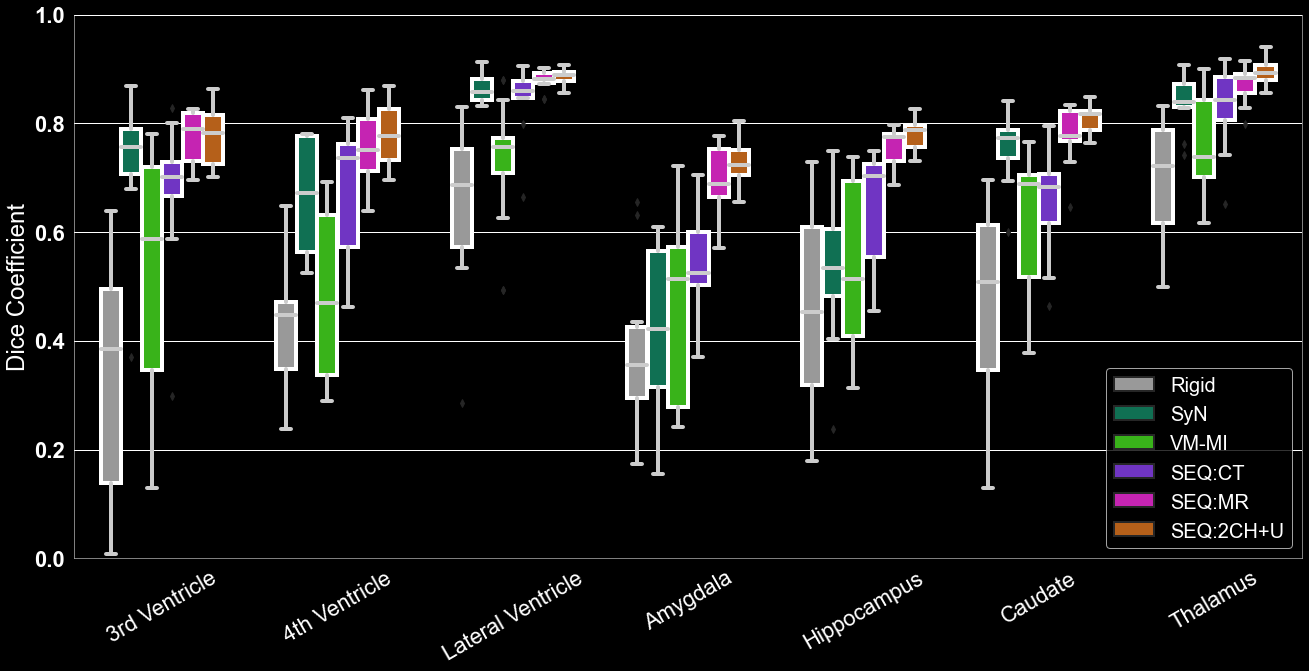

In [13]:
# colors = [(0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
#  (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
#  (1.0, 1.0, 0.2),
#  (1.0, 0.4980392156862745, 0.0),
#  (0.85882353, 0.08627451, 0.65490196),
#  (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
#  (0.07843137, 0.85490196, 0.87058824)]

plt.figure(figsize=(22,10))
# sns.set(context='paper',style='whitegrid',font_scale = 3)
sns.set(style='darkgrid', font_scale=2, 
        rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'grid.linewidth':1, 'axes.linewidth':0.5,
            'xtick.color':'white','ytick.color':'white','axes.edgecolor':'white', 'text.color': 'white', 'axes.labelcolor': 'white',})
# sns.set(style='whitegrid', font_scale = 2)
# g = sns.boxplot(y='Dice', x='anatomy', data=df, hue='method', hue_order=['Rigid','SyN','VM-MI','VM-Seg','SEQ:CT','SEQ:MR','SEQ:MR+Multi','SEQ:2CH','SEQ:2CH+U'], width=0.7,linewidth=4, palette=sns.color_palette(colors), #'Set1_r'
g = sns.boxplot(y='Dice', x='anatomy', data=df, hue='method', hue_order=['Rigid','SyN','VM-MI','SEQ:CT','SEQ:MR','SEQ:2CH+U'], width=0.7,linewidth=4, palette=sns.color_palette(colors), #'Set1_r'
                order=['3rd', '4th','LV','amygdala', 'hippocampus', 'caudate', 'thalamus'], **{'boxprops':{'edgecolor':'white'}})
g.set(ylim=(0.0, 1.0), xlabel=None)
plt.legend(fontsize='small', loc='lower right')
plt.xticks(np.arange(7),['3rd Ventricle','4th Ventricle', 'Lateral Ventricle', 'Amygdala','Hippocampus','Caudate','Thalamus'],rotation=30)
plt.yticks(weight='bold')
plt.ylabel('Dice Coefficient')
plt.setp(g.lines, color=".8")
plt.show()

In [8]:
plt.style.use("dark_background")

In [ ]:
plt.figure(figsize=(22,10))
# sns.set(style='darkgrid', font_scale=2, 
#         rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'grid.linewidth':1, 'axes.linewidth':0.5,
#             'xtick.color':'white','ytick.color':'white','axes.edgecolor':'white', 'text.color': 'white'})
g = sns.boxplot(y='SD', x='anatomy', data=df, hue='method', hue_order=['Rigid','SyN','VM-MI','SEQ:CT','SEQ:MR','SEQ:2CH','SEQ:2CH+U','Xu et al.'], width=0.7,linewidth=4, palette=(sns.color_palette(colors)),
                order=['3rd', '4th','LV','amygdala', 'hippocampus', 'caudate', 'thalamus'])#, **{'boxprops':{'edgecolor':'white'}})
g.set(xlabel=None, ylabel='SD (mm)')
g.set(ylim=(0.0, 2.5), xlabel=None)
plt.legend(fontsize='x-small', loc='upper right')
plt.yticks(weight='bold')
plt.xticks(np.arange(7),['3rd Ventricle','4th Ventricle', 'Lateral Ventricle', 'Amygdala','Hippocampus','Caudate','Thalamus'],rotation=30)
# plt.setp(g.lines, color=".8")
plt.show()

In [ ]:
colors = [(0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (1.0, 1.0, 0.2),
 (1.0, 0.4980392156862745, 0.0),
 (0.85882353, 0.08627451, 0.65490196),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.07843137, 0.85490196, 0.87058824)]
sns.set_palette(sns.color_palette(colors))

In [ ]:
# colors = [(1.0, 0.4980392156862745, 0.0), (0.87058824, 0.13333333, 0.09411765), (0,0,0),
#          (0.85882353, 0.08627451, 0.65490196), (0.596078431372549, 0.3058823529411765, 0.6392156862745098), (0,0,0),
#          (0.07843137, 0.85490196, 0.87058824), (0.21568627450980393, 0.49411764705882355, 0.7215686274509804)]
colors = [ (140, 140, 140), (0,0,0), (139, 0, 139), (244, 154, 194), (0,0,0),
 (255, 0, 255), (238, 130, 238), (0,0,0),
 (255, 215, 0), (255,255,150)]
colors = np.array(colors) / 255.0
#df = pd.read_csv('MR_CT_2channel_allmetrics.csv')
fig = plt.figure(figsize=(22,10))
sns.set(context='paper',style='whitegrid',font_scale = 3)
# sns.set(style='darkgrid', font_scale=2, 
#         rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'grid.linewidth':1, 'axes.linewidth':0.5,
#             'xtick.color':'white','ytick.color':'white','axes.edgecolor':'white', 'text.color': 'white', 'axes.labelcolor': 'white',})
# sns.set(style='whitegrid', font_scale = 2)
#with plt.rc_context({'axes.edgecolor':'white', 'xtick.color':'white', 'ytick.color':'black', 'figure.facecolor':'black'}):
g = sns.boxplot(y='Dice', x='anatomy', data=df, hue='method', hue_order=['Rigid','','SEQ:CT','E2E:CT','','SEQ:MR','E2E:MR','','SEQ:2CH+U','E2E:2CH+U'], width=0.7,linewidth=4, palette=sns.set_palette(sns.color_palette(colors)), #'Set1_r',
                order=['3rd', '4th','LV','amygdala', 'hippocampus', 'caudate', 'thalamus']) #, **{'boxprops':{'edgecolor':'white', 'linewidth':1.5}})
g.set(ylim=(0.0, 1.0), xlabel=None)
plt.legend(fontsize='small', loc='lower right')
plt.xticks(np.arange(7),['3rd Ventricle','4th Ventricle', 'Lateral Ventricle', 'Amygdala','Hippocampus','Caudate','Thalamus'], rotation=30)
# plt.setp(g.lines, color=".8")
plt.yticks(weight='bold')
plt.ylabel('Dice Coefficient')
plt.show()

In [ ]:
plt.figure(figsize=(22,10))
g = sns.boxplot(y='SD', x='anatomy', data=df, hue='method', hue_order=['S+R:CT','E2E:CT','','S+R:MR','E2E:MR','','S+R:2channel+uncertainty','E2E:2channel+uncertainty'], width=0.7,linewidth=4, palette=sns.set_palette(sns.color_palette(colors)),
                order=['3rd', '4th','LV','amygdala', 'hippocampus', 'caudate', 'thalamus'])
g.set(ylim=(0.0, 1.2), xlabel=None, ylabel='SD (mm)')
plt.legend(fontsize='x-small', loc='upper right')
plt.yticks(weight='bold')
plt.show()

plt.figure(figsize=(22,10))
g = sns.boxplot(y='HD', x='anatomy', data=df, hue='method', hue_order=['S+R:CT','E2E:CT','','S+R:MR','E2E:MR','','S+R:2channel+uncertainty','E2E:2channel+uncertainty'], width=0.7,linewidth=4, palette=sns.set_palette(sns.color_palette(colors)),
                order=['3rd', '4th','LV','amygdala', 'hippocampus', 'caudate', 'thalamus'])
g.set(ylim=(0.0, 5.5), xlabel=None, ylabel='HD (mm)')
plt.legend(fontsize='x-small', loc='upper right')
plt.yticks(weight='bold')
plt.show()

In [ ]:
TRE = pd.read_csv('TRE.csv')
sns.set(style='whitegrid', font_scale = 2)
plt.figure(figsize=(20,20))
g = sns.boxplot(y='TRE', x='method', order=['rigid', 'SyN','MI-VM', 'S+R:CT', 'S+R:MR', 'S+R:2channel', 'S+R:2channel+uncertainty','E2E:S+R:2channel+uncertainty'], data=TRE, width=0.7,linewidth=4, palette='Set1_r')
g.set(xlabel=None)
plt.xticks(rotation=30, weight='bold')

In [ ]:
TRE = pd.read_csv('TRE.csv')
sns.set(style='whitegrid', font_scale = 2)
plt.figure(figsize=(20,20))
g = sns.boxplot(y='TRE', x='method', order=['S+R:CT','E2E:CT','','S+R:MR','E2E:MR','','S+R:2channel+uncertainty','E2E:2channel+uncertainty'], data=TRE, width=0.7,linewidth=4, palette=sns.set_palette(sns.color_palette(colors)))
g.set(xlabel=None, ylim=(0,6), ylabel='TRE (mm)')
plt.xticks(rotation=30, weight='bold')

## New RadOnc Data with deformation

In [ ]:
config = dict()
config['data_dir'] = r"\\istar-blackhole\data2\data2\RadOnc_Brain\NonRigid_Training_CBCT"
config['valid_dir'] = r"\\istar-blackhole\data2\data2\RadOnc_Brain\Validation"
config['write_dir'] = r"\\istar-tauceti\c_users\U01_BrainRegistration\temp\CBCT_synth"
config['image_size'] = [128,160,128]#[192,240,192]

config['G_path'] = './checkpoint/LSGAN/LSGAN_MR_CT_prob_generator_149.h5'
config['F_path'] = './checkpoint/LSGAN/LSGAN_CT_MR_prob_generator_149.h5'
G = Generator(config['image_size']+[1], prob=True)
G.load_weights(config['G_path'])
F = Generator(config['image_size']+[1], prob=True)
F.load_weights(config['F_path'])

def registration_model(config):
    nf_enc = [16, 32, 64, 128, 128]
    nf_dec = [128, 64, 32, 16]
    R_CT = networks.deformable_net2(config['image_size'], nf_enc, nf_dec, n_channel=1, use_svf=True)
    R_MR = networks.deformable_net2(config['image_size'], nf_enc, nf_dec, n_channel=1, use_svf=True)

    mr_moving = Input(shape=config['image_size']+[1])
    ct_fixed = Input(shape=config['image_size']+[1])
    mr_fixed = Input(shape=config['image_size']+[1])
    ct_moving = Input(shape=config['image_size']+[1])

    flow_MR = R_MR([mr_moving, mr_fixed])
    flow_CT = R_CT([ct_moving, ct_fixed])
    flow = concatenate([flow_MR, flow_CT])
    flow = tf.keras.layers.Conv3D(3, 3, strides=1, padding='same')(flow)
#     flow = tf.keras.layers.Conv3D(6, 3, strides=1, padding='same')(flow)
#     flow = tf.keras.layers.Conv3D(3, 1, strides=1)(flow)
    flow = vxm.layers.VecInt(method='ss', name='flow', int_steps=7)(flow)
    R = Model(inputs=[mr_moving, ct_moving, mr_fixed, ct_fixed], outputs=flow)
    return R

R = registration_model(config)
R.load_weights('./checkpoint/VM/2channel/fusion1/checkpoint_2channel_fusion_224.h5')

In [ ]:
# from utils import normalizeImage
# CT_min = -100.0
# CT_max = 100.0
# T1_min = -100.0
# T1_max = 2300.0
# index = [19,29,31,35,44,46]

# for i in tqdm(index):
#     mr_moving = nib.load(os.path.join(r'E:\c_users\U01_BrainRegistration\NormalAnatomy_deformation', f'A{i:02}', f'T1_rigid_{i:02}.nii.gz')).get_fdata()
#     mr_moving = normalizeImage(mr_moving, T1_max, T1_min)
#     ct_fixed = nib.load(os.path.join(r'E:\c_users\U01_BrainRegistration\NormalAnatomy',f'atlas_brain_{i:02}_CT-crop-resampled.nii')).get_fdata()
#     ct_fixed = normalizeImage(ct_fixed, CT_max, CT_min)
#     ct_fixed = resize(ct_fixed, config['image_size'])
#     mr_moving = resize(mr_moving, config['image_size'])

#     # read segmentations
#     mask_moving = nib.load(os.path.join(r'E:\c_users\U01_BrainRegistration\NormalAnatomy_deformation',f'T1_rigid_{i:02}_MALPEM.nii.gz')).get_fdata()
#     mask_fixed = nib.load(os.path.join(r'\\istar-blackhole\data2\data2\RadOnc_Brain\MALPEM-MR-Brain-Segmentations',f'atlas_brain_{i:02}_T1-crop-resampled_MALPEM.nii.gz')).get_fdata()
#     mask_moving = np.squeeze(mask_moving)
#     mask_fixed = resize(np.squeeze(mask_fixed), config['image_size'], order=0, anti_aliasing=False)
    
#     image = nib.Nifti1Image(ct_fixed, None)
#     image.to_filename(os.path.join(r'E:\c_users\U01_BrainRegistration\Validation_RadOnc',f"RadOnc_{i:02}_CT.nii.gz"))
#     image = nib.Nifti1Image(mask_fixed.astype(np.int16), None)
#     image.to_filename(os.path.join(r'E:\c_users\U01_BrainRegistration\Validation_RadOnc',f"RadOnc_{i:02}_CT_MALPEM.nii.gz"))

#     image = nib.Nifti1Image(mr_moving, None)
#     image.to_filename(os.path.join(r'E:\c_users\U01_BrainRegistration\Validation_RadOnc',f"RadOnc_{i:02}_MR.nii.gz"))
#     image = nib.Nifti1Image(mask_moving.astype(np.int16), None)
#     image.to_filename(os.path.join(r'E:\c_users\U01_BrainRegistration\Validation_RadOnc',f"RadOnc_{i:02}_MR_MALPEM.nii.gz"))

In [ ]:
from utils import normalizeImage
CT_min = -100.0
CT_max = 100.0
T1_min = -100.0
T1_max = 2300.0
dice_before_total = []
dice_after_total = []
hd_before_total = []
sd_before_total = []
hd_after_total = []
sd_after_total = []
index = [6,8,17,19,29,31,35,44,46] #6,8,17,
for i in tqdm(index):
    mr_moving = nib.load(os.path.join(r'E:\c_users\U01_BrainRegistration\NormalAnatomy_deformation',f'T1_rigid_{i:02}.nii.gz')).get_fdata()
    mr_moving = normalizeImage(mr_moving, T1_max, T1_min)
    ct_fixed = nib.load(os.path.join(r'E:\c_users\U01_BrainRegistration\NormalAnatomy',f'atlas_brain_{i:02}_CT-crop-resampled.nii')).get_fdata()
    ct_fixed = normalizeImage(ct_fixed, CT_max, CT_min)
    ct_fixed = tf.cast(np.expand_dims(resize(ct_fixed, config['image_size']),axis=[0,-1]), tf.float32)
    mr_moving = tf.cast(np.expand_dims(resize(mr_moving, config['image_size']),axis=[0,-1]), tf.float32)

    # read segmentations
    mask_moving = nib.load(os.path.join(r'E:\c_users\U01_BrainRegistration\NormalAnatomy_deformation',f'T1_rigid_{i:02}_MALPEM.nii.gz')).get_fdata()
    mask_fixed = nib.load(os.path.join(r'\\istar-blackhole\data2\data2\RadOnc_Brain\MALPEM-MR-Brain-Segmentations',f'atlas_brain_{i:02}_T1-crop-resampled_MALPEM.nii.gz')).get_fdata()
    mask_moving = np.squeeze(mask_moving)
    mask_fixed = resize(np.squeeze(mask_fixed), config['image_size'], order=0, anti_aliasing=False)
    mask_val = [0,1,2,23,5,19,29,8]
    for val in [6,20,24,30,9]:
        mask_fixed[mask_fixed==val] -= 1
        mask_moving[mask_moving==val] -= 1
    mask_moving = tf.cast(np.expand_dims(mask_moving,axis=[0,-1]), tf.float32)
    mask_fixed = tf.cast(np.expand_dims(mask_fixed,axis=[0,-1]), tf.float32)

    ct_moving, _ = G(mr_moving)
    mr_fixed, _ = F(ct_fixed)
    flow = R([mr_moving, ct_moving, mr_fixed, ct_fixed])
#     _, flow = R([mr_moving, ct_fixed])
#     mr_fixed, _, ct_moving, _, flow = GR([mr_moving, ct_fixed])
    mr_reg = vxm.layers.SpatialTransformer(interp_method='linear', indexing='ij')([mr_moving, flow])
    mask_reg = vxm.layers.SpatialTransformer(interp_method='nearest', indexing='ij')([mask_moving, flow])

#     TRE_before.append(compute_TRE(np.squeeze(ventricle_fixed.numpy()), np.squeeze(ventricle_moving.numpy()), spacing))
#     TRE_after.append(compute_TRE(np.squeeze(ventricle_fixed.numpy()), np.squeeze(ventricle_registered.numpy()), spacing))
    islice = 70
    fig, ax = plt.subplots(1,3,figsize=(20,20))
    np.vectorize(lambda ax: ax.axis('off'))(ax)
    ax[0].imshow(np.squeeze(mr_moving.numpy())[:,:,islice].T, cmap='gray', vmin=0.1, vmax=0.4)
    ax[0].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,islice], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#     ax[1].imshow(np.squeeze(mr_fixed.numpy())[:,:,islice].T, cmap='gray', vmin=0.1, vmax=0.4)
#     ax[1].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,islice], sigma=1).T, cmap=colormap_binary('green', alpha=1))
    ax[1].imshow(np.squeeze(mr_reg.numpy())[:,:,islice].T, cmap='gray', vmin=0.1, vmax=0.4)
    ax[1].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,islice], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#     ax[3].imshow(np.squeeze(ct_moving.numpy())[:,:,islice].T, cmap='gray', vmin=0.4, vmax=0.9)
#     ax[3].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,islice], sigma=1).T, cmap=colormap_binary('green', alpha=1))
    ax[2].imshow(np.squeeze(ct_fixed.numpy())[:,:,islice].T, cmap='gray', vmin=0.4, vmax=0.9)
    ax[2].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,islice], sigma=1).T, cmap=colormap_binary('green', alpha=1))
    plt.show()

    mask_fixed = np.squeeze(mask_fixed.numpy())
    mask_moving = np.squeeze(mask_moving.numpy())
    mask_reg = np.squeeze(mask_reg.numpy())

    dice_before = []
    dice_after = []
    hd_before = []
    sd_before = []
    hd_after = []
    sd_after = []
    for val in mask_val[1:]:
        dice_before.append(surface_distance.compute_dice_coefficient(mask_fixed==val, mask_moving==val))
        dice_after.append(surface_distance.compute_dice_coefficient(mask_fixed==val, mask_reg==val))
        metrics_before = compute_surface_metrics(mask_fixed==val, mask_moving==val)
        metrics_after = compute_surface_metrics(mask_fixed==val, mask_reg==val)
        hd_before.append(metrics_before['hd'])
        hd_after.append(metrics_after['hd'])
        sd_before.append(metrics_before['avg_dist'])
        sd_after.append(metrics_after['avg_dist'])
    dice_before_total.append(dice_before)
    dice_after_total.append(dice_after)
    hd_before_total.append(hd_before)
    hd_after_total.append(hd_after)
    sd_before_total.append(sd_before)
    sd_after_total.append(sd_after)

In [ ]:
# d0 = pd.DataFrame()
# for i in range(len(TRE_before)):
#     temp_df = {'TRE':TRE_before[i], 'method':['rigid']*len(TRE_before[i])}
#     temp_df = pd.DataFrame(data=temp_df)
#     d0 = pd.concat([d0, temp_df])

# d1 = pd.DataFrame()
# for i in range(len(TRE_after)):
#     temp_df = {'TRE':TRE_after[i], 'method':['E2E:2channel']*len(TRE_after[i])}
#     temp_df = pd.DataFrame(data=temp_df)
#     d1 = pd.concat([d1, temp_df])

# TRE = pd.concat([TRE,d1])
# TRE.groupby(['method']).agg({'TRE':['mean','std']})
TRE = pd.read_csv('TRE_RadOnc_real.csv')
sns.set(style='whitegrid', font_scale = 2)
plt.figure(figsize=(10,10))
g = sns.boxplot(y='TRE', x='method', order=['rigid', 'SyN','MI-VM', 'E2E:2channel+uncertainty'], data=TRE, width=0.7,linewidth=4, palette='Set1_r')
g.set(xlabel=None, ylabel='TRE (mm)')
plt.xticks(rotation=30, weight='bold')

In [ ]:
df = pd.read_csv('MR_CT_RadOnc_real.csv')

# df = df[df['method']!='rigid']
# d0 = {'Dice':np.reshape(np.array(dice_before_total),-1),'HD':np.reshape(np.array(hd_before_total),-1), 'SD':np.reshape(np.array(sd_before_total),-1),
#       'anatomy':['3rd', '4th','LV','amygdala', 'hippocampus', 'thalamus', 'caudate']*len(index),'method':['rigid']*7*len(index)}
# d0 = pd.DataFrame(data=d0)
# df = pd.concat([df,d0])
# d1 = {'Dice':np.reshape(np.array(dice_after_total),-1),'HD':np.reshape(np.array(hd_after_total),-1), 'SD':np.reshape(np.array(sd_after_total),-1),
#       'anatomy':['3rd', '4th','LV','amygdala', 'hippocampus', 'thalamus', 'caudate']*len(index),'method':['E2E:2channel+uncertainty']*7*len(index)}
# d1 = pd.DataFrame(data=d1)
# df = pd.concat([df,d1])
# # df.to_csv('MR_CT_RadOnc_real.csv')
# df.loc[df['method']=='E2E:2channel', 'method'] = 'E2E:2channel+uncertainty'

In [ ]:
TRE = pd.read_csv("TRE_RadOnc_real.csv")
TRE.groupby(['method']).agg({'TRE': ['mean','std','count']})
#df.groupby(['method']).agg({"Dice": ["mean","std"], "SD": ['mean', 'std'], 'HD': ['mean', 'std']})

In [ ]:
TRE.to_csv("TRE_RadOnc_real.csv")

In [ ]:
plt.figure(figsize=(15,5))
sns.set(style='whitegrid', font_scale = 2)
g = sns.boxplot(y='Dice', x='anatomy', data=df, hue='method', hue_order=['rigid','SyN','MI-VM','E2E:2channel+uncertainty'], width=0.7,linewidth=4, palette='Set1_r',
                order=['3rd', '4th','LV','amygdala', 'hippocampus', 'caudate', 'thalamus'])
g.set(ylim=(0.0, 1.0), xlabel=None)
plt.legend(fontsize='x-small', loc='lower center')
plt.yticks(weight='bold')
plt.show()

plt.figure(figsize=(15,5))
sns.set(style='whitegrid', font_scale = 2)
g = sns.boxplot(y='SD', x='anatomy', data=df, hue='method', hue_order=['rigid','SyN','MI-VM','E2E:2channel+uncertainty'], width=0.7,linewidth=4, palette='Set1_r',
                order=['3rd', '4th','LV','amygdala', 'hippocampus', 'caudate', 'thalamus'])
g.set(xlabel=None, ylabel='SD (mm)')
plt.legend(fontsize='x-small', loc='upper center')
plt.yticks(weight='bold')
plt.show()

plt.figure(figsize=(15,5))
sns.set(style='whitegrid', font_scale = 2)
g = sns.boxplot(y='HD', x='anatomy', data=df, hue='method', hue_order=['rigid','SyN','MI-VM','E2E:2channel+uncertainty'], width=0.7,linewidth=4, palette='Set1_r',
                order=['3rd', '4th','LV','amygdala', 'hippocampus', 'caudate', 'thalamus'])
g.set(xlabel=None, ylabel='HD (mm)')
plt.legend(fontsize='x-small', loc='upper right')
plt.yticks(weight='bold')
plt.show()

In [ ]:
sns.set(style='whitegrid', font_scale = 2)
plt.figure(figsize=(10,10))
g = sns.boxplot(y='TRE', x='method', order=['rigid','SyN','MI-VM','E2E:2channel+uncertainty'], data=TRE, width=0.7,linewidth=4, palette='Set1_r')
g.set(xlabel=None, ylim=(0,6), ylabel='TRE (mm)')
plt.xticks(rotation=30, weight='bold')

## HeadScanner

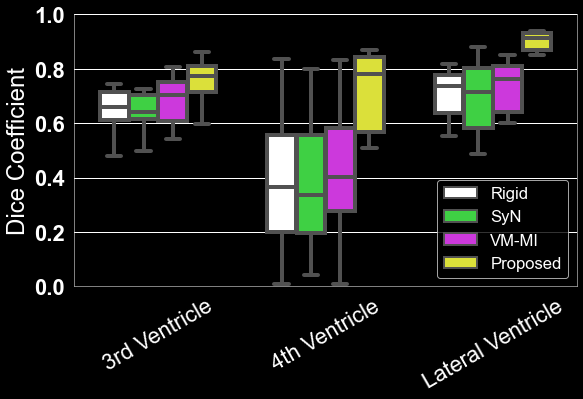

In [5]:
df = pd.read_csv('MR_CT_HeadScanner.csv')
df.loc[df['method']=='rigid','method'] = 'Rigid'
df.loc[df['method']=='E2E:2channel+uncertainty','method'] = 'Proposed'
df.loc[df['method']=='MI-VM','method'] = 'VM-MI'
colors = [(255, 255, 255),
 (39, 232, 46),
 (226, 30, 247),
 (245, 252, 30)]
colors = np.array(colors) / 255

plt.figure(figsize=(9,5))
sns.set(style='darkgrid', font_scale=2, 
        rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'grid.linewidth':1, 'axes.linewidth':0.5,
            'xtick.color':'white','ytick.color':'white','axes.edgecolor':'white', 'text.color': 'white', 'axes.labelcolor': 'white',})
g = sns.boxplot(y='Dice', x='anatomy', data=df, hue='method', hue_order=['Rigid','SyN','VM-MI','Proposed'], width=0.7,linewidth=4, palette=sns.color_palette(colors),
                order=['3rd', '4th','LV'])
g.set(ylim=(0.0, 1.0), xlabel=None)
plt.legend(fontsize='x-small', loc='lower right')
plt.xticks(np.arange(3),['3rd Ventricle','4th Ventricle', 'Lateral Ventricle'],rotation=30)
plt.yticks(weight='bold')
plt.ylabel('Dice Coefficient')
plt.show()

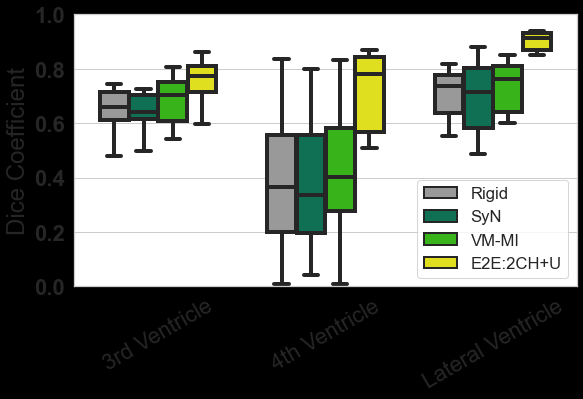

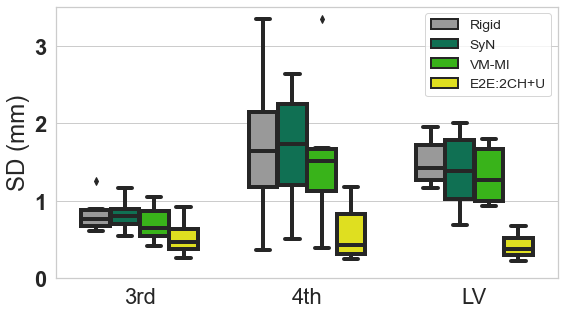

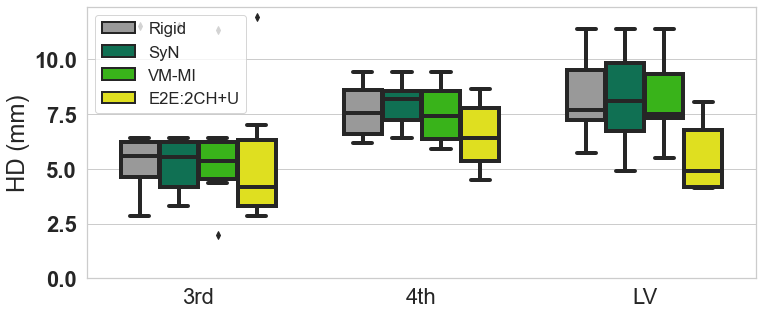

In [2]:
df = pd.read_csv('MR_CT_HeadScanner.csv')
df.loc[df['method']=='rigid','method'] = 'Rigid'
df.loc[df['method']=='E2E:2channel+uncertainty','method'] = 'E2E:2CH+U'
df.loc[df['method']=='MI-VM','method'] = 'VM-MI'
colors = [(0.6, 0.6, 0.6),
  (0, 0.502, 0.349),
 (0.165, 0.802, 0.00),
 (1, 1, 0)]

plt.figure(figsize=(9,5))
sns.set(style='whitegrid', font_scale = 2)
g = sns.boxplot(y='Dice', x='anatomy', data=df, hue='method', hue_order=['Rigid','SyN','VM-MI','E2E:2CH+U'], width=0.7,linewidth=4, palette=sns.color_palette(colors),
                order=['3rd', '4th','LV'])
g.set(ylim=(0.0, 1.0), xlabel=None)
plt.legend(fontsize='x-small', loc='lower right')
plt.xticks(np.arange(3),['3rd Ventricle','4th Ventricle', 'Lateral Ventricle'],rotation=30)
plt.yticks(weight='bold')
plt.ylabel('Dice Coefficient')
plt.show()

plt.figure(figsize=(9,5))
sns.set(style='whitegrid', font_scale = 2)
g = sns.boxplot(y='SD', x='anatomy', data=df, hue='method', hue_order=['Rigid','SyN','VM-MI','E2E:2CH+U'], width=0.7,linewidth=4, palette=sns.color_palette(colors),
                order=['3rd', '4th','LV'])
g.set(ylim=(0.0, None), xlabel=None, ylabel='SD (mm)')
plt.legend(fontsize='xx-small', loc='upper right')
plt.yticks(weight='bold')
plt.show()

plt.figure(figsize=(12,5))
sns.set(style='whitegrid', font_scale = 2)
g = sns.boxplot(y='HD', x='anatomy', data=df, hue='method', hue_order=['Rigid','SyN','VM-MI','E2E:2CH+U'], width=0.7,linewidth=4, palette=sns.color_palette(colors),
                order=['3rd', '4th','LV'])
g.set(ylim=(0.0, None), xlabel=None, ylabel='HD (mm)')
plt.legend(fontsize='x-small', loc='upper left')
plt.yticks(weight='bold')
plt.show()

In [ ]:
TRE = pd.read_csv('TRE_HeadScanner.csv')
TRE.loc[TRE['method']=='E2E:2channel+uncertainty','method'] = 'E2E:2CH+U'
TRE.loc[TRE['method']=='rigid','method'] = 'Rigid'
TRE.loc[TRE['method']=='MI-VM','method'] = 'VM-MI'
sns.set(style='whitegrid', font_scale = 2)
plt.figure(figsize=(5,5))
g = sns.boxplot(y='TRE', x='method', order=['Rigid', 'SyN','VM-MI', 'E2E:2CH+U'], data=TRE, width=0.7,linewidth=4, palette=sns.color_palette(colors))
g.set(xlabel=None, ylabel='TRE (mm)')
plt.xticks(rotation=30)
plt.yticks(weight='bold')

In [ ]:
#df.groupby(['method']).agg({"Dice": ["mean","std"], "SD": ['mean', 'std'], 'HD': ['mean', 'std']})

TRE.groupby(['method']).agg({'TRE': ['mean','std']})

# Probabilistic Registration

In [ ]:
from tensorflow.keras.initializers import RandomNormal, Constant
import tensorflow_probability as tfp

def registration_model(config):
    src = Input(shape=config['image_size']+[1])
    tgt = Input(shape=config['image_size']+[1])

    nf_enc = [16, 32, 64, 128, 256]
    nf_dec = [128, 64, 32, 16]
    model = networks.deformable_net2(config['image_size'], nf_enc, nf_dec, n_channel=1, use_svf=True)

    v = model([src, tgt])
    flow_mean = tf.keras.layers.Conv3D(3, kernel_size=3, padding='same',
                       kernel_initializer=RandomNormal(mean=0.0, stddev=1e-5))(v)
    # we're going to initialize the velocity variance very low, to start stable.
    flow_log_sigma = tf.keras.layers.Conv3D(3, kernel_size=3, padding='same',
                            kernel_initializer=RandomNormal(mean=0.0, stddev=1e-10),
                            bias_initializer=Constant(value=-10))(v)
    flow_params = concatenate([flow_mean, flow_log_sigma])
    #flow = Sample(name="z_sample")([flow_mean, flow_log_sigma])
    flow = tfp.distributions.Sample(tfp.distributions.Normal(flow_mean, tf.exp(flow_log_sigma))).sample()
    flow = vxm.layers.VecInt(method='ss', int_steps=7)(flow)
    return Model(inputs=[src, tgt], outputs=[flow, flow_params])

R = registration_model(config)
R.load_weights('./checkpoint/VM/ProbabilisticReg_MR_MR_174.h5')

In [ ]:
dice_ep = pd.DataFrame()
for ep in range(5):
    R.load_weights('./checkpoint/VM/ProbabilisticReg_MR_MR_{}.h5'.format(124+ep*25))
    dice_before_total = []
    dice_after_total= []
    mask_val = [0,1,2,23,24,5,19,29,8]

    for i in tqdm(range(10)):
        valid_ds = np.load(glob.glob(os.path.join(config['valid_dir'],'*.npz'))[i])
        example_ct = valid_ds['fixed_img']
        example_mr = valid_ds['moving_img']
        ct_fixed = tf.cast(np.expand_dims(resize(example_ct, config['image_size']),axis=[0,-1]), tf.float32)
        mr_moving = tf.cast(np.expand_dims(resize(example_mr, config['image_size']),axis=[0,-1]), tf.float32)
        mr_fixed, _ = F(ct_fixed)
        [flow, flow_params] = R([mr_moving, mr_fixed])
#         ct_moving, _ = G(mr_moving)
#         mr_reg = vxm.layers.SpatialTransformer(interp_method='linear', indexing='ij')([mr_moving, flow])

#         fig, ax = plt.subplots(1,6,figsize=(20,20))
#         np.vectorize(lambda ax: ax.axis('off'))(ax)
#         ax[0].imshow(np.squeeze(ct_fixed.numpy())[:,:,70].T, cmap='gray', vmin=0.4, vmax=0.9)
#         ax[0].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         ax[1].imshow(np.squeeze(mr_moving.numpy())[:,:,70].T, cmap='gray')
#         ax[1].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         ax[2].imshow(np.squeeze(mr_reg.numpy())[:,:,70].T, cmap='gray')
#         ax[2].imshow(canny(np.squeeze(ct_fixed.numpy())[:,:,70], sigma=1).T, cmap=colormap_binary('green', alpha=1))
#         ax[3].imshow(np.squeeze(tf.exp(flow_params[..., 3:]).numpy())[:,:,70,0].T)
#         ax[4].imshow(np.squeeze(tf.exp(flow_params[..., 3:]).numpy())[:,:,70,1].T)
#         ax[5].imshow(np.squeeze(tf.exp(flow_params[..., 3:]).numpy())[:,:,70,2].T)
#         plt.show()

        ventricle_fixed = valid_ds['ventricle_fixed']
        ventricle_moving = valid_ds['ventricle_moving']
        for val in [6,20,30,9]:
            ventricle_fixed[ventricle_fixed==val] -= 1
            ventricle_moving[ventricle_moving==val] -= 1
        mask_fixed = np.zeros(ventricle_fixed.shape)
        mask_moving = np.zeros(ventricle_moving.shape)
        for val in mask_val[1:]:
            mask_fixed += (ventricle_fixed==val)
            mask_moving += (ventricle_moving==val)
        ventricle_fixed = np.multiply(ventricle_fixed, mask_fixed)
        ventricle_moving = np.multiply(ventricle_moving, mask_moving)
    
        ventricle_fixed = tf.cast(np.expand_dims(resize(ventricle_fixed, config['image_size'], order=0, anti_aliasing=False), [0,-1]), tf.float32)
        ventricle_moving = tf.cast(np.expand_dims(resize(ventricle_moving, config['image_size'], order=0, anti_aliasing=False), [0,-1]), tf.float32)
        transformer = vxm.layers.SpatialTransformer(interp_method='nearest', indexing='ij')
        ventricle_warp = transformer([ventricle_moving, flow])
        dice_before = []
        dice_after= []
    #np.unique(ventricle_warp)
        for val in mask_val[1:]:
            mask_fixed = tf.cast(ventricle_fixed==val, tf.float32)
#             mask_moving = tf.cast(ventricle_moving==val, tf.float32)
            mask_registered = tf.cast(ventricle_warp==val, tf.float32)
#             dice_before.append(-losses.binary_dice(mask_fixed,mask_moving).numpy())
            dice_after.append(-losses.binary_dice(mask_fixed,mask_registered).numpy())
#         dice_before_total.append(dice_before)
        dice_after_total.append(dice_after)
    d = {'Dice':np.reshape(np.array(dice_after_total),-1),
      'anatomy':['3rd', '4th','LV', 'RV','amygdala', 'hippocampus', 'thalamus', 'caudate']*10,'ep':[str(124+ep*25)]*80}
    d = pd.DataFrame(data=d)
    dice_ep = pd.concat([dice_ep, d])

In [ ]:
pd.set_option('display.max_rows', None)
dice_ep.groupby(['anatomy','ep']).agg({"Dice": ["mean"]})

In [ ]:
d2 = {'Dice':np.reshape(np.array(dice_after_total),-1),
      'anatomy':['3rd', '4th','LV', 'RV','amygdala', 'hippocampus', 'thalamus', 'caudate']*10,'method':['probabilistic_reg_MR']*80}
d2 = pd.DataFrame(data=d2)
# df = pd.concat([d1,d2])
df = pd.concat([df,d2])

In [ ]:
plt.figure(figsize=(20,8))
#sns.set(context='paper',style='whitegrid',font_scale = 3)
#sns.set(style='darkgrid', font_scale=2, rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'grid.linewidth':1, 'axes.linewidth':1})
sns.set(style='whitegrid', font_scale = 2)
#with plt.rc_context({'axes.edgecolor':'white', 'xtick.color':'white', 'ytick.color':'black', 'figure.facecolor':'black'}):
g = sns.boxplot(y='Dice', x='anatomy', data=df, hue='method', hue_order=['rigid','MR_MR', 'MR_MR_prob', 'probabilistic_reg_MR'], width=0.7,linewidth=4, palette='Set1_r',
                order=['3rd', '4th','LV','amygdala', 'hippocampus', 'caudate', 'thalamus'])
g.set(ylim=(0.0, 1.0), xlabel=None, ylabel=None)
plt.legend(fontsize='x-small', loc='lower right')
#plt.xticks(rotation=30, weight='bold')
plt.yticks(weight='bold')
plt.show()

# Patch Image Registration

In [ ]:
def patch_wise_prediction(model, data, patch_size, overlap=0, batch_size=1):
    predictions = list()
    indices = patches.compute_patch_indices(np.shape(data), patch_size=patch_size, overlap=overlap)
    batch = list()
    i = 0
    while i < len(indices):
        while len(batch) < batch_size:
            patch = patches.get_patch_from_3d_data(data, patch_shape=patch_size, patch_index=indices[i])
            batch.append(np.expand_dims(patch, axis=-1))
            i += 1
        prediction = model.predict(np.asarray(batch))
        batch = list()
        for predicted_patch in prediction:
            predictions.append(np.squeeze(predicted_patch))
    return patches.reconstruct_from_patches(predictions, patch_indices=indices, data_shape=np.shape(data))

def patch_wise_prediction_JSR(G, src, tgt, patch_size, overlap=0, batch_size=1):
    predictions_src = list()
    predictions_tgt = list()
    indices = patches.compute_patch_indices(np.shape(src), patch_size=patch_size, overlap=overlap)
    for i in range(len(indices)):
        patch_src = patches.get_patch_from_3d_data(src, patch_shape=patch_size, patch_index=indices[i])
        patch_tgt = patches.get_patch_from_3d_data(tgt, patch_shape=patch_size, patch_index=indices[i])

        [src_synth, tgt_synth, flow] = JSR([tf.cast(np.expand_dims(patch_src,axis=[0,-1]),tf.float32), tf.cast(np.expand_dims(patch_tgt,axis=[0,-1]),tf.float32)])
        predictions_src.append(np.squeeze(src_synth.numpy()))
        predictions_tgt.append(np.squeeze(tgt_synth.numpy()))
    #return patches.reconstruct_from_patches(predictions_src, patch_indices=indices, data_shape=np.shape(src)), patches.reconstruct_from_patches(predictions_tgt, patch_indices=indices, data_shape=np.shape(src))
    return reconstruct_from_patches(predictions_src, predictions_tgt, indices, np.shape(src))

def reconstruct_from_patches(patches_src, patches_tgt, patch_indices, data_shape, default_value=0):
    """
    Reconstructs an array of the original shape from the lists of patches and corresponding patch indices. Overlapping
    patches are averaged.
    :param patches: List of numpy array patches.
    :param patch_indices: List of indices that corresponds to the list of patches.
    :param data_shape: Shape of the array from which the patches were extracted.
    :param default_value: The default value of the resulting data. if the patch coverage is complete, this value will
    be overwritten.
    :return: numpy array containing the data reconstructed by the patches.
    """
    data_src = np.ones(data_shape) * default_value
    data_tgt = np.ones(data_shape) * default_value
    image_shape = data_shape[-3:]
    count = np.zeros(data_shape, dtype=np.int)
    for patch_src, patch_tgt, index in zip(patches_src, patches_tgt, patch_indices):
        image_patch_shape = patch_src.shape[-3:]
        if np.any(index < 0):
            fix_patch = np.asarray((index < 0) * np.abs(index), dtype=np.int)
            patch_src = patch_src[..., fix_patch[0]:, fix_patch[1]:, fix_patch[2]:]
            patch_tgt = patch_tgt[..., fix_patch[0]:, fix_patch[1]:, fix_patch[2]:]
            index[index < 0] = 0
        if np.any((index + image_patch_shape) >= image_shape):
            fix_patch = np.asarray(image_patch_shape - (((index + image_patch_shape) >= image_shape)
                                                        * ((index + image_patch_shape) - image_shape)), dtype=np.int)
            patch_src = patch_src[..., :fix_patch[0], :fix_patch[1], :fix_patch[2]]
            patch_tgt = patch_tgt[..., :fix_patch[0], :fix_patch[1], :fix_patch[2]]
        patch_index = np.zeros(data_shape, dtype=np.bool)
        patch_index[...,
                    index[0]:index[0]+patch_src.shape[-3],
                    index[1]:index[1]+patch_src.shape[-2],
                    index[2]:index[2]+patch_src.shape[-1]] = True
        patch_src_data = np.zeros(data_shape)
        patch_src_data[patch_index] = patch_src.flatten()
        patch_tgt_data = np.zeros(data_shape)
        patch_tgt_data[patch_index] = patch_tgt.flatten()
        
        new_data_index = np.logical_and(patch_index, np.logical_not(count > 0))
        data_src[new_data_index] = patch_src_data[new_data_index]
        data_tgt[new_data_index] = patch_tgt_data[new_data_index]

        averaged_data_index = np.logical_and(patch_index, count > 0)
        if np.any(averaged_data_index):
            data_src[averaged_data_index] = (data_src[averaged_data_index] * count[averaged_data_index] + patch_src_data[averaged_data_index]) / (count[averaged_data_index] + 1)
            data_tgt[averaged_data_index] = (data_tgt[averaged_data_index] * count[averaged_data_index] + patch_tgt_data[averaged_data_index]) / (count[averaged_data_index] + 1)
        count[patch_index] += 1
    return data_src, data_tgt

In [ ]:
config = dict()
config['train_dir'] = "//istar-blackhole/data2/data2/RadOnc_Brain/fullres_deform/train"
config['valid_dir'] = "//istar-blackhole/data2/data2/RadOnc_Brain/fullres_deform/valid"
config['patch_size'] = [96,96,96]
config['overlap'] = [32,32,32]
config['G_CBCT_dir'] = './checkpoint/LSGAN/96/LSGAN_patch96_CBCT_CT_generator_249.h5'
config['G_MR_dir'] = './checkpoint/LSGAN/96/LSGAN_patch96_MR_CT_generator_249.h5'

JSR = networks.JSR2(config['patch_size'], config['G_MR_dir'], config['G_CBCT_dir'])

In [ ]:
valid_ds = np.load(glob.glob(os.path.join(config['valid_dir'],'*.npz'))[0])
src = valid_ds['moving_img']
tgt = valid_ds['cbct']
src_truth = valid_ds['fixed_warp']
tgt_truth = valid_ds['fixed_img']
# src = tf.cast(np.expand_dims(src,axis=[0,-1]),tf.float32)
# tgt = tf.cast(np.expand_dims(tgt,axis=[0,-1]),tf.float32)

In [ ]:
config['write_dir'] = r'E:\c_users\U01_BrainRegistration\temp'

mr_img = nib.Nifti1Image(valid_ds['moving_truth'],np.eye(4,4))
mr_img.to_filename(os.path.join(config['write_dir'],f"RadOnc_JSR_valid_{0:02}_MR_truth.nii.gz"))

In [ ]:
src_synth, tgt_synth = patch_wise_prediction_JSR(JSR, src, tgt, np.asarray(config['patch_size']), np.asarray(config['overlap']))
#src_synth, tgt_synth, indices = patch_wise_prediction_JSR(JSR, src, tgt, np.asarray(config['patch_size']), np.asarray(config['overlap']))

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(15,15))
islice=90
ax[0,0].imshow(np.squeeze(src)[:,:,islice], cmap='gray')
ax[0,1].imshow(np.squeeze(src_truth)[:,:,islice], cmap='gray')
ax[0,2].imshow(np.squeeze(src_synth)[:,:,islice], cmap='gray')
ax[1,0].imshow(np.squeeze(tgt)[:,:,islice], cmap='gray')
ax[1,1].imshow(np.squeeze(tgt_truth)[:,:,islice], cmap='gray')
ax[1,2].imshow(np.squeeze(tgt_synth)[:,:,islice], cmap='gray')
#plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.tight_layout()

In [ ]:
nf_enc = [16, 32, 64, 128, 256]
nf_dec = [128, 64, 32, 16]
config['image_size'] = [128,160,128]
model = networks.deformable_net2(config['image_size'], nf_enc, nf_dec)
model.load_weights('./checkpoint/checkpoint_model2_CBCT_Synth_lr0.000100.hdf5')

In [ ]:
dice_before_total = []
dice_after_total= []
Dice = losses.binary_dice

for i in range(10):
    valid_ds = np.load(glob.glob(os.path.join(config['valid_dir'],'*.npz'))[i])
    cbct = valid_ds['cbct']
    #example_ct = valid_ds['fixed_img']
    mr = valid_ds['moving_img']
    #example_mr_synth = valid_ds['moving_synth']

    mr_synth, cbct_synth = patch_wise_prediction_JSR(JSR, mr, cbct, np.asarray(config['patch_size']), np.asarray(config['overlap']))
    
    cbct_synth_tf = tf.cast(np.expand_dims(resize(cbct_synth, config['image_size']),axis=[0,-1]), tf.float32)
    mr_synth_tf = tf.cast(np.expand_dims(resize(mr_synth, config['image_size']),axis=[0,-1]), tf.float32)
    [mr_synth_warp, flow] = model([mr_synth_tf,cbct_synth_tf])
#example_mr_warp = resize(np.squeeze(mr_warp.numpy()), example_mr.shape)

    flow_resize = np.squeeze(flow.numpy())
    for j in range(3):
        flow_resize[:,:,:,j] = flow_resize[:,:,:,j]*(mr.shape[j]/config['image_size'][j])
    flow_resize = resize(np.squeeze(flow_resize), mr.shape+(3,))
    transformer_linear = nrn_layers.SpatialTransformer(interp_method='linear', indexing='ij')
    mr_warp = transformer_linear([tf.cast(np.expand_dims(mr,axis=[0,-1]), tf.float32),tf.cast(np.expand_dims(flow_resize,axis=[0]), tf.float32)])
    mr_warp = np.squeeze(mr_warp.numpy())
#     ventricle_fixed = valid_ds['ventricle_fixed']
#     ventricle_moving = valid_ds['ventricle_moving']
#     ventricle_fixed = tf.cast(np.expand_dims(ventricle_fixed, [0,-1]), tf.float32)
#     ventricle_moving = tf.cast(np.expand_dims(ventricle_moving, [0,-1]), tf.float32)
#     transformer = nrn_layers.SpatialTransformer(interp_method='nearest', indexing='ij')
#     ventricle_warp = transformer([ventricle_moving, tf.cast(np.expand_dims(flow_resize,axis=[0]), tf.float32)])
#     dice_before = []
#     dice_after= []
#     mask_val = np.unique(ventricle_warp)
#     for val in mask_val[1:]:
#         mask_fixed = tf.cast(ventricle_fixed==val, tf.float32)
#         mask_moving = tf.cast(ventricle_moving==val, tf.float32)
#         mask_registered = tf.cast(ventricle_warp==val, tf.float32)
#         dice_before.append(-Dice(mask_fixed,mask_moving).numpy())
#         dice_after.append(-Dice(mask_fixed,mask_registered).numpy())
#     dice_before_total.append(dice_before)
#     dice_after_total.append(dice_after)
    
    config['write_dir'] = r'E:\c_users\U01_BrainRegistration\temp'
    cbct_img = nib.Nifti1Image(cbct,np.eye(4,4))
    cbct_img.to_filename(os.path.join(config['write_dir'],f"RadOnc_JSR_valid_{i:02}_CBCT.nii.gz"))
    mr_img = nib.Nifti1Image(mr,np.eye(4,4))
    mr_img.to_filename(os.path.join(config['write_dir'],f"RadOnc_JSR_valid_{i:02}_MR.nii.gz"))
    cbct_gen_img = nib.Nifti1Image(cbct_synth,np.eye(4,4))
    cbct_gen_img.to_filename(os.path.join(config['write_dir'],f"RadOnc_JSR_valid_{i:02}_CBCT_synth.nii.gz"))
    mr_gen_img = nib.Nifti1Image(mr_synth,np.eye(4,4))
    mr_gen_img.to_filename(os.path.join(config['write_dir'],f"RadOnc_JSR_valid_{i:02}_MR_synth.nii.gz"))
    ct_img = nib.Nifti1Image(valid_ds['fixed_img'],np.eye(4,4))
    ct_img.to_filename(os.path.join(config['write_dir'],f"RadOnc_JSR_valid_{i:02}_CT.nii.gz"))
    mr_reg_img = nib.Nifti1Image(mr_warp,np.eye(4,4))
    mr_reg_img.to_filename(os.path.join(config['write_dir'],f"RadOnc_JSR_valid_{i:02}_MR_reg.nii.gz"))

In [ ]:
os.path.join(config['write_dir'],f"RadOnc_JSR_valid_{i:02}_CBCT.nii.gz")

In [ ]:
from tensorflow.keras.models import Model
import neuron.layers as nrn_layers
model_SVF = Model(inputs=model.inputs, outputs=model.layers[-3].output)

def flow_MSE(flow_truth, flow_inv, ventricle_moving, ratio=2.5):
    error = []
    edge = np.gradient((np.squeeze(ventricle_moving)>0.01).astype(np.float))
    edge = np.linalg.norm(edge,axis=0)
    X, Y, Z = np.where(edge>0)
    print(flow_truth.shape, flow_inv.shape, ventricle_moving.shape)
    for (x,y,z) in zip(X,Y,Z):
        flow_sample = flow_truth[0,x,y,z,:]/ratio
        flow_inv_sample = flow_inv[x,y,z,:]
        error.append(np.linalg.norm(flow_sample-flow_inv_sample))
    return np.array(error)

In [ ]:
SVF = model_SVF([mr_synth_tf,cbct_synth_tf])
flow_inv = nrn_layers.VecInt(method='ss', int_steps=7)(-SVF)
flow_inv_resize = np.squeeze(flow_inv.numpy())
for i in range(3):
    flow_inv_resize[:,:,:,i] = flow_inv_resize[:,:,:,i]*(mr.shape[i]/config['image_size'][i])
flow_inv_resize = resize(np.squeeze(flow_inv_resize), mr.shape+(3,))

In [ ]:
flow_error = flow_MSE(valid_ds['flow'], flow_inv_resize, valid_ds['ventricle_moving'], ratio=2.5)
print(np.mean(flow_error), np.std(flow_error))

In [ ]:
import pickle
import pandas as pd
file = open('Dice_Results.pkl', 'rb')
df = pickle.load(file)
file.close()

# d = {'Dice':np.reshape(np.array(dice_after_total)+0.05,-1),'anatomy':['3rd', '4th','right','left']*10,'method':['JSR']*40}
# d = pd.DataFrame(data=d)

# df = pd.concat([df,d])

In [ ]:
df.groupby(['method','anatomy']).std()

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,9))
#sns.set(context='paper',style='whitegrid',font_scale = 3)
sns.set(style='whitegrid', font_scale=4, rc={'grid.linewidth':4, 'axes.linewidth':4})
g = sns.boxplot(y='Dice', x='method', data=df, hue='anatomy', hue_order=['3rd','4th','left','right',], width=0.5,linewidth=4,
                #order=['before', 'SyN', 'MI-Voxelmorph', 'MI-R', 'Synth+R', 'End-to-End','SyN_CBCT','CBCT_MI', 'CBCT_NCC','JSR'], palette="cubehelix")
                order=['before', 'SyN_CBCT','JSR'])
g.set(ylim=(0.0, 1.0))
plt.legend(fontsize='xx-small')
g.set(ylabel='Dice', xticklabels=['Before','SyN','JSR'])
plt.show()